In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression, RANSACRegressor
from scipy.spatial.distance import cdist
from scipy.optimize import minimize_scalar
import os
import json

### Plot a Frame

In [2]:
def plot_frame_positions(tracking, frame_id, annotate=True):
    frame_data = tracking[tracking["frame_id"] == frame_id]

    if frame_data.empty:
        print(f"No data found for frame_id={frame_id}")
        return

    x_min, x_max = -52.5, 52.5
    y_min, y_max = -34, 34

    plt.figure(figsize=(10, 7))

    plt.plot([x_min, x_max, x_max, x_min, x_min], 
             [y_min, y_min, y_max, y_max, y_min], color="black")

    ball_data = frame_data[frame_data["player_id"] == "ball"]
    player_data = frame_data[frame_data["player_id"] != "ball"]

    teams = player_data["team_id"].unique()

    if len(teams) >= 2:
        team1, team2 = teams[:2]
    else:
        print("Warning: less than 2 teams detected")
        team1, team2 = teams[0], None


    team1_data = player_data[player_data["team_id"] == team1]
    team1_data = team1_data[team1_data["x"].notna()]
    plt.scatter(team1_data["x"], team1_data["y"], 
                c="blue", label=f"Team {team1}", s=80, edgecolor="black")
    if annotate:
        for _, row in team1_data.iterrows():
            label = row["jersey_number"] if "jersey_number" in row else row["player_id"]
            plt.text(row["x"], row["y"]+0.8, str(label), ha="center", fontsize=8, color="blue")

    if team2 is not None:
        team2_data = player_data[player_data["team_id"] == team2]
        team2_data = team2_data[team2_data["x"].notna()]
        plt.scatter(team2_data["x"], team2_data["y"], 
                    c="red", label=f"Team {team2}", s=80, edgecolor="black")
        if annotate:
            for _, row in team2_data.iterrows():
                label = row["jersey_number"] if "jersey_number" in row else row["player_id"]
                plt.text(row["x"], row["y"]+0.8, str(label), ha="center", fontsize=8, color="red")

    if not ball_data.empty:
        plt.scatter(ball_data["x"], ball_data["y"], 
                    c="yellow", marker="o", s=120, edgecolor="black", label="Ball")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Player & Ball Positions (Frame {frame_id})")
    plt.xlabel("X (Pitch length in meters)")
    plt.ylabel("Y (Pitch width in meters)")
    plt.legend()
    plt.show()

#     plot_frame_positions(tracking, frame, annotate=True)

In [ ]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

def plot_frame_positions_mplsoccer(tracking, frame_id, team_mapping=None, annotate=True):
    frame_data = tracking[tracking["frame_id"] == frame_id]

    if frame_data.empty:
        print(f"No data found for frame_id={frame_id}")
        return

    pitch = Pitch(pitch_type='custom', 
                  pitch_length=105, pitch_width=68, pitch_color='green',
                  line_color='white')
    fig, ax = pitch.draw(figsize=(10, 7))

    ball_data = frame_data[frame_data["player_id"] == "ball"]
    player_data = frame_data[frame_data["player_id"] != "ball"]

    teams = player_data["team_id"].unique()
    if len(teams) >= 2:
        team1, team2 = teams[:2]
    else:
        print("Warning: less than 2 teams detected")
        team1, team2 = teams[0], None

    t1_label = team_mapping.get(team1, f"Team {team1}") if team_mapping else f"Team {team1}"
    t2_label = team_mapping.get(team2, f"Team {team2}") if team_mapping else f"Team {team2}"

    team1_data = player_data[player_data["team_id"] == team1].dropna(subset=["x", "y"])
    pitch.scatter(team1_data["x"] + 52.5, team1_data["y"] + 34,
                  c="blue", edgecolors="black", s=80, ax=ax, label=t1_label)
    if annotate:
        for _, row in team1_data.iterrows():
            label = int(row["jersey_number"]) if "jersey_number" in row else row["player_id"]
            pitch.annotate(str(label), (row["x"] + 52.5, row["y"] + 34),
                           ax=ax, ha="center", va="bottom", fontsize=12, color="black")

    if team2 is not None:
        team2_data = player_data[player_data["team_id"] == team2].dropna(subset=["x", "y"])
        pitch.scatter(team2_data["x"] + 52.5, team2_data["y"] + 34,
                      c="red", edgecolors="black", s=80, ax=ax, label=t2_label)
        if annotate:
            for _, row in team2_data.iterrows():
                label = int(row["jersey_number"]) if "jersey_number" in row else row["player_id"]
                pitch.annotate(str(label), (row["x"] + 52.5, row["y"] + 34),
                               ax=ax, ha="center", va="bottom", fontsize=12, color="black")

    if not ball_data.empty:
        pitch.scatter(ball_data["x"] + 52.5, ball_data["y"] + 34,
                      c="yellow", edgecolors="black", s=120, ax=ax, label="Ball", marker="o")

    ax.set_title(f"Player & Ball Positions (Frame {frame_id})")
    ax.legend()
    plt.show()

### Extract Back line Count

In [4]:
def filter_attacking_third(df):
        if 'third_end' in df.columns:
            return df[df['third_end'] == 'attacking_third']
        elif 'third_start' in df.columns:
            return df[df['third_start'] == 'attacking_third']
        else:
            print("Warning: No third column found for filtering")
            return df

def extract_back_line_formation(defensive_structure):
        if pd.isna(defensive_structure):
            return None
        formation_str = str(defensive_structure)
        try:
            return int(formation_str[0])
        except (ValueError, IndexError):
            return None
        

def count_back_line_defenders_kmeans(df, frame_id, direction, team_in_possession, max_clusters=4, plot=True, remove_keeper=True):
    frame_df = df[df['frame_id'] == frame_id]
    frame_df = frame_df[frame_df['team_id'] != 'ball']
    frame_df = frame_df[frame_df['team_id'].notna()]
    
    defending_team = frame_df[frame_df['team_id'] != team_in_possession].iloc[0]['team_id']
    defenders = frame_df[frame_df['team_id'] == defending_team].copy()
    if defenders.empty:
        return 0
    defenders = defenders[defenders['x'].notna()]
    
    if remove_keeper and not defenders.empty:
        if direction == "right_to_left":
            keeper_idx = defenders['x'].idxmin()
        elif direction == "left_to_right":
            keeper_idx = defenders['x'].idxmax()
        else:
            raise ValueError("direction must be 'left_to_right' or 'right_to_left'")
        defenders = defenders.drop(keeper_idx)
    
    if defenders.empty:
        return 0
    

    X = defenders[['x']].to_numpy()
    n_clusters = min(len(defenders), max_clusters)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(X)
    defenders['cluster'] = kmeans.labels_
    
    centers = kmeans.cluster_centers_.flatten()
    
    if direction == "right_to_left":
        back_line_cluster = np.argmin(centers)
    elif direction == "left_to_right":
        back_line_cluster = np.argmax(centers)
    
    back_line_count = (defenders['cluster'] == back_line_cluster).sum()
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(defenders['x'], defenders['y'], 
                    c=defenders['cluster'], cmap='tab10', s=80, edgecolor='k')
        
        back_line_players = defenders[defenders['cluster'] == back_line_cluster]
        plt.scatter(back_line_players['x'], back_line_players['y'], 
                    c='red', s=150, edgecolor='black', marker='o', label='Back line')
        
        for c in centers:
            plt.axvline(x=c, color='gray', linestyle='--', alpha=0.5)
        
        plt.gca().invert_yaxis()
        plt.xlabel("X position")
        plt.ylabel("Y position")
        plt.title(f"Frame {frame_id} - Defending team {defending_team} clusters (keeper removed)")
        plt.legend()
        plt.show()
    
    return back_line_count



### Filter Dataset

In [5]:

poss_keep = [
    "event_id","match_id","frame_start","frame_end",
    "player_id","player_name","player_position",
    "team_id","team_shortname",
    "x_start","y_start","x_end","y_end",
    "defensive_structure","n_defensive_lines",
    "pass_distance","pass_range","pass_angle","pass_direction",
    "player_targeted_xthreat",
    "n_passing_options","n_off_ball_runs", "pass_outcome", "lead_to_shot", "lead_to_goal", "pass_ahead", "channel_start",
    "channel_end", "third_start", "third_end", "attacking_side", "team_in_possession_phase_type"
]
pass_opts_keep = [
    "event_id","match_id","frame_start","frame_end",
    "player_id","player_name","player_position", "team_id",
    "player_in_possession_id","player_in_possession_name",
    "x_start","y_start","x_end","y_end",
    "defensive_structure","n_defensive_lines",
    "first_line_break","last_line_break","n_opponents_bypassed",
    "xthreat","passing_option_score","xpass_completion",
    "targeted","received","dangerous", "penalty_area_start", "penalty_area_end", "associated_off_ball_run_event_id",
    "pass_range", "pass_distance", "pass_ahead", "channel_start",
    "channel_end", "third_start", "third_end", "attacking_side", "team_in_possession_phase_type"
]

runs_keep = [
    "event_id","match_id","frame_start","frame_end",
    "player_id","player_name","player_position",
    "x_start","y_start","x_end","y_end",
    "channel_start","channel_end","third_start","third_end",
    "intended_run_behind","break_defensive_line","push_defensive_line",
    "xthreat","n_opponents_ahead_start","n_opponents_ahead_end","lead_to_shot", "lead_to_goal", "passing_option_score", "difficult_pass_target", "targeted", "received", "dangerous", "penalty_area_start", "penalty_area_end", "attacking_side"
]

tracking_keep = [
    "timestamp","frame_id", "period",
    "player_id","player_name","team_id","team_name",
    "x","y","speed","jersey_number","ball_state","ball_owning_team_id"
]


### Populate Backline

In [6]:
from collections import Counter

def populate_backline_info(df, tracking_data):
    if 'defensive_structure' in df.columns.tolist():
        df['back_line_count'] = df['defensive_structure'].apply(extract_back_line_formation)
        allowed_formations = [3,4,5]
        for i, row in df.iterrows():
            if pd.isna(row['back_line_count']):
                backline_counts = []
                frame_start = row['frame_start']
                frame_end = row['frame_end']
                for frame_id in range(frame_start, frame_end+1):
                    df.at[i,'back_line_count'] = count = count_back_line_defenders_kmeans(tracking_data, frame_id=row['frame_start'], direction=row['attacking_side'], team_in_possession = row['team_id'], plot=False)
                    backline_counts.append(count)
                if backline_counts:
                    most_common = Counter(backline_counts).most_common(1)[0][0]
                    df.at[i, 'back_line_count'] = most_common

        # print(df['back_line_count'].value_counts())
        df = df[df['back_line_count'].isin(allowed_formations)]
        # print(df['back_line_count'].value_counts())
        
    else:
        print("Defensive Structure column not found")
    return df

### Load the Data

In [7]:
BATCH_SIZE = 30
TRACKER_FILE = "processed_csv/batch_tracker.json"
OUTPUT_DIR = "processed_csv"

matches_df = pd.read_csv('matches.csv')

match_ids = matches_df['match_id'].astype(int).tolist()

team_mapping = {}
for _, row in matches_df.iterrows():
    team_mapping[row['home_team_id']] = row['home_team_name']
    team_mapping[row['away_team_id']] = row['away_team_name']
team_mapping = {int(k): v for k, v in team_mapping.items()}

if os.path.exists(TRACKER_FILE):
    with open(TRACKER_FILE, "r") as f:
        tracker = json.load(f)
else:
    tracker = {"last_completed_batch": 0}
    
    
total_batches = (len(match_ids) + BATCH_SIZE - 1) // BATCH_SIZE
next_batch = tracker["last_completed_batch"] + 1

if next_batch > total_batches:
    print("All batches already processed.")

else:

    print(f"Starting batch {next_batch}/{total_batches}...")

    match_batches = [match_ids[i:i + BATCH_SIZE] for i in range(0, len(match_ids), BATCH_SIZE)]
    current_batch_ids = match_batches[next_batch - 1]

    off_ball_analysis = None
    passing_analysis = None
    possessions_analysis = None
    passing_offball_merged = None
    processed_count = 0

    for match_id in current_batch_ids:
        match_path = f"zips/{match_id}"
        if not os.path.exists(match_path):
            print(f"Skipping {match_id} (no folder found)")
            continue

        try:
            off_ball_runs = pd.read_csv(f"{match_path}/off_ball_runs.csv")
            passing_options = pd.read_csv(f"{match_path}/passing_options.csv")
            player_possessions = pd.read_csv(f"{match_path}/player_possessions.csv")
            tracking_data = pd.read_csv(f"{match_path}/tracking.csv")

            player_possessions = player_possessions[[c for c in poss_keep if c in player_possessions.columns]]
            passing_options = passing_options[[c for c in pass_opts_keep if c in passing_options.columns]]
            off_ball_runs = off_ball_runs[[c for c in runs_keep if c in off_ball_runs.columns]]
            tracking_data = tracking_data[[c for c in tracking_keep if c in tracking_data.columns]]

            off_ball_analysis_curr = filter_attacking_third(off_ball_runs)
            off_ball_analysis_curr['data_source'] = 'off_ball_runs'

            passing_analysis_curr = filter_attacking_third(passing_options)
            passing_analysis_curr['data_source'] = 'passing_options'
            passing_analysis_curr = populate_backline_info(passing_analysis_curr, tracking_data)

            possessions_analysis_curr = filter_attacking_third(player_possessions)
            possessions_analysis_curr['data_source'] = 'player_possessions'
            possessions_analysis_curr = populate_backline_info(possessions_analysis_curr, tracking_data)

            passing_offball_merged_curr = passing_analysis_curr.merge(
                off_ball_analysis_curr, how='left',
                left_on='associated_off_ball_run_event_id', right_on='event_id'
            )

            off_ball_analysis = pd.concat([off_ball_analysis, off_ball_analysis_curr], ignore_index=True) if off_ball_analysis is not None else off_ball_analysis_curr
            passing_analysis = pd.concat([passing_analysis, passing_analysis_curr], ignore_index=True) if passing_analysis is not None else passing_analysis_curr
            possessions_analysis = pd.concat([possessions_analysis, possessions_analysis_curr], ignore_index=True) if possessions_analysis is not None else possessions_analysis_curr
            passing_offball_merged = pd.concat([passing_offball_merged, passing_offball_merged_curr], ignore_index=True) if passing_offball_merged is not None else passing_offball_merged_curr

            processed_count += 1
            print(f"{match_id} loaded ({processed_count}/{len(current_batch_ids)})")

        except Exception as e:
            print(f"Error processing {match_id}: {e}")
            continue
        
    print(f"Saving batch {next_batch} outputs...")

    off_ball_analysis.to_csv(f"{OUTPUT_DIR}/batch_{next_batch}_off_ball_analysis.csv", index=False)
    passing_analysis.to_csv(f"{OUTPUT_DIR}/batch_{next_batch}_passing_analysis.csv", index=False)
    possessions_analysis.to_csv(f"{OUTPUT_DIR}/batch_{next_batch}_possessions_analysis.csv", index=False)
    passing_offball_merged.to_csv(f"{OUTPUT_DIR}/batch_{next_batch}_passing_offball_merged.csv", index=False)

    tracker["last_completed_batch"] = next_batch
    with open(TRACKER_FILE, "w") as f:
        json.dump(tracker, f, indent=4)

    print(f"Batch {next_batch} completed and tracker updated!")


All batches already processed.


In [10]:
import os
import pandas as pd

checkpoint_dir = "processed_csv"

# Define the four file categories
categories = [
    "off_ball_analysis",
    "passing_analysis",
    "possessions_analysis",
    "passing_offball_merged"
]

combined_dfs = {}

for category in categories:
    print(f"Processing category: {category}...")
    
    files = sorted([
        os.path.join(checkpoint_dir, f)
        for f in os.listdir(checkpoint_dir)
        if f.startswith("batch_") and f.endswith(f"{category}.csv")
    ])
    
    dfs = []
    for fpath in files:
        try:
            df = pd.read_csv(fpath)
            dfs.append(df)
            print(f"  Loaded: {fpath} ({len(df)} rows)")
        except Exception as e:
            print(f" Skipping {fpath} due to error: {e}")
    
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_dfs[category] = combined_df
        
        # Save final merged CSV
        final_path = os.path.join(checkpoint_dir, f"final_merged_{category}.csv")
        combined_df.to_csv(final_path, index=False)
        print(f"Saved merged file: {final_path} ({len(combined_df)} rows)")
    else:
        print(f"No batch files found for {category}")

print("All merged files saved successfully!")


Processing category: off_ball_analysis...
  Loaded: processed_csv/batch_1_off_ball_analysis.csv (5614 rows)
  Loaded: processed_csv/batch_2_off_ball_analysis.csv (5606 rows)
  Loaded: processed_csv/batch_3_off_ball_analysis.csv (5410 rows)
  Loaded: processed_csv/batch_4_off_ball_analysis.csv (5628 rows)
  Loaded: processed_csv/batch_5_off_ball_analysis.csv (5503 rows)
  Loaded: processed_csv/batch_6_off_ball_analysis.csv (5299 rows)
  Loaded: processed_csv/batch_7_off_ball_analysis.csv (5519 rows)
  Loaded: processed_csv/batch_8_off_ball_analysis.csv (584 rows)
Saved merged file: processed_csv/final_merged_off_ball_analysis.csv (39163 rows)
Processing category: passing_analysis...
  Loaded: processed_csv/batch_1_passing_analysis.csv (15593 rows)
  Loaded: processed_csv/batch_2_passing_analysis.csv (15552 rows)
  Loaded: processed_csv/batch_3_passing_analysis.csv (15035 rows)
  Loaded: processed_csv/batch_4_passing_analysis.csv (16568 rows)
  Loaded: processed_csv/batch_5_passing_analy

### START OF CODE After Creating Dataset

In [4]:
matches_df = pd.read_csv('matches.csv')

match_ids = matches_df['match_id'].astype(int).tolist()

team_mapping = {}
for _, row in matches_df.iterrows():
    team_mapping[row['home_team_id']] = row['home_team_name']
    team_mapping[row['away_team_id']] = row['away_team_name']
team_mapping = {int(k): v for k, v in team_mapping.items()}

opponent_lookup = {}

for _, row in matches_df.iterrows():
    opponent_lookup[(row['match_id'], row['home_team_id'])] = row['away_team_id']
    opponent_lookup[(row['match_id'], row['away_team_id'])] = row['home_team_id']

off_ball_analysis = pd.read_csv("processed_csv/final_merged_off_ball_analysis.csv")

passing_analysis = pd.read_csv("processed_csv/final_merged_passing_analysis.csv")
passing_analysis = passing_analysis[passing_analysis['team_in_possession_phase_type']!='set_play']
passing_analysis['opponent_id'] = passing_analysis.apply(
    lambda r: opponent_lookup.get((r['match_id'], r['team_id'])), axis=1
)
passing_analysis['opponent_name'] = passing_analysis['opponent_id'].map(team_mapping)

possessions_analysis = pd.read_csv("processed_csv/final_merged_possessions_analysis.csv")
possessions_analysis = possessions_analysis[possessions_analysis['team_in_possession_phase_type']!='set_play']
possessions_analysis['opponent_id'] = possessions_analysis.apply(
    lambda r: opponent_lookup.get((r['match_id'], r['team_id'])), axis=1
)
possessions_analysis['opponent_name'] = possessions_analysis['opponent_id'].map(team_mapping)

passing_offball_merged = pd.read_csv("processed_csv/final_merged_passing_offball_merged.csv")
passing_offball_merged = passing_offball_merged[passing_offball_merged['team_in_possession_phase_type']!='set_play']

possessions_analysis['back_line_count'] = possessions_analysis['back_line_count'].astype(int)
passing_offball_merged['back_line_count'] = passing_offball_merged['back_line_count'].astype(int)
passing_analysis['back_line_count'] = passing_analysis['back_line_count'].astype(int)

possessions_order = sorted(passing_offball_merged["back_line_count"].dropna().unique()) 


channel_order = ['wide_left', 'half_space_left', 'center', 'half_space_right', 'wide_right']
channel_order_formatted = ['wide left', 'half space left', 'center', 'half space right', 'wide right']
classified_channel_order=['Wide','Half-space','Central']
pass_range_order = ["short", "medium", "long"]
phase_type_order = ['chaotic','create','finish','quick break','transition','direct']


In [4]:
colors = {
    3: '#1F77B4',
    4: '#FF7F0E',
    5: '#9467BD'
}
colors_str = {
    '3': '#1F77B4',
    '4': '#FF7F0E',
    '5': '#9467BD'
}


                      team_name                                     league  \
0  Arsenal Football Club, Women  ENG - FA Women`s Super League - 2023/2024   
1    Kansas City Current, Women                          USA - NWSL - 2023   
2         San Diego Wave, Women                          USA - NWSL - 2023   
3      Chicago Red Stars, Women                          USA - NWSL - 2023   
4            OL Reign FC, Women                          USA - NWSL - 2023   

   home_games  away_games  total_games  
0          11          11           22  
1          11          11           22  
2          11          11           22  
3          11          10           21  
4          11          10           21  


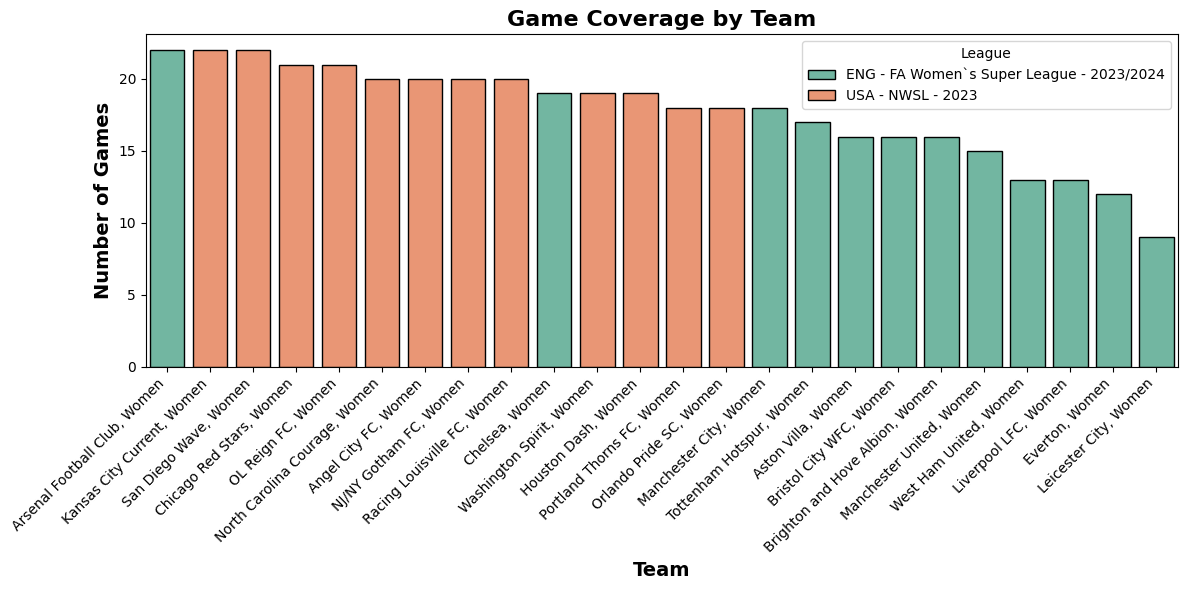

In [5]:
home_team_games = matches_df.groupby(['home_team_name','competition_edition_name']).agg(home_games = ('match_id','count')).reset_index()
home_team_games = home_team_games.rename(columns={'home_team_name':'team_name'})

away_team_games = matches_df.groupby(['away_team_name', 'competition_edition_name']).agg(away_games = ('match_id','count')).reset_index()
away_team_games = away_team_games.rename(columns={'away_team_name':'team_name'})

all_games = home_team_games.merge(away_team_games, how = 'inner', on=('team_name','competition_edition_name'))
all_games['total_games'] = all_games['home_games'] + all_games['away_games']
all_games = all_games.sort_values('total_games',ascending=False).reset_index(drop=True)
all_games = all_games.rename(columns={'competition_edition_name':'league'})


print(all_games.head())

plt.figure(figsize=(12, 6))

sns.barplot(
        data=all_games,
        x='team_name', y='total_games', hue='league',
        dodge=False, palette='Set2', edgecolor='black'
    )
plt.legend(title='League')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Team', fontsize=14, fontweight='bold')
plt.ylabel('Number of Games', fontsize=14, fontweight='bold')
plt.title('Game Coverage by Team', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


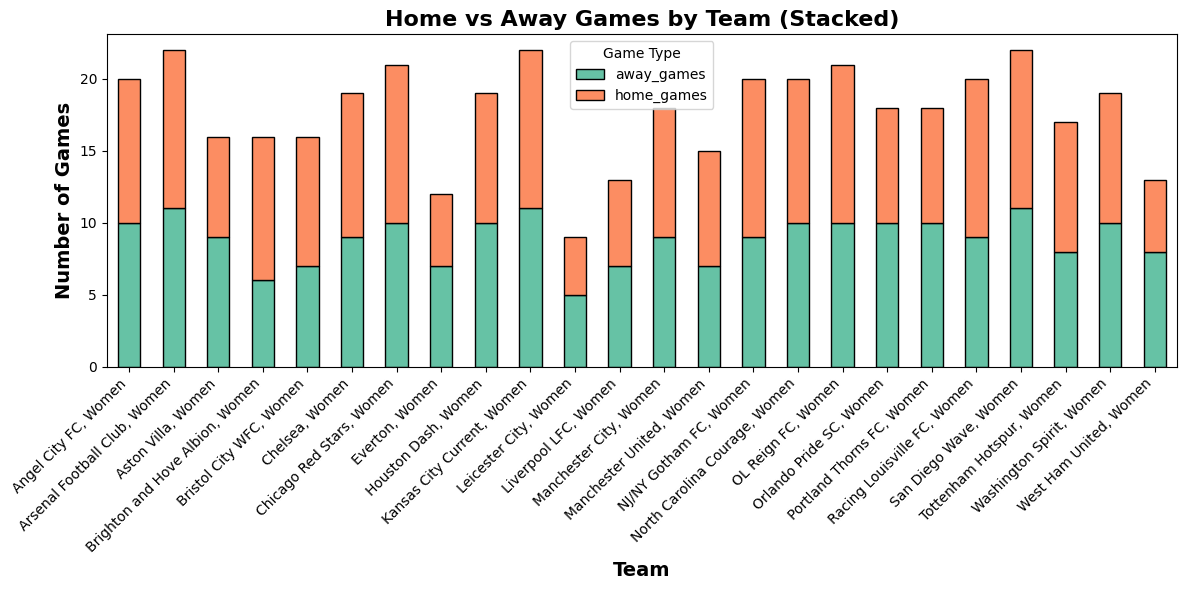

In [23]:
games_long = all_games.melt(
    id_vars=['team_name', 'league'],
    value_vars=['home_games', 'away_games'],
    var_name='game_type',
    value_name='games'
)
games_stacked = (
    games_long
    .pivot_table(index=['team_name', 'league'], columns='game_type', values='games', fill_value=0)
    .reset_index()
)

games_stacked.plot(
    x='team_name',
    kind='bar',
    stacked=True,
    color=['#66c2a5', '#fc8d62'],
    edgecolor='black',
    figsize=(12, 6)
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Team', fontsize=14, fontweight='bold')
plt.ylabel('Number of Games', fontsize=14, fontweight='bold')
plt.title('Home vs Away Games by Team (Stacked)', fontsize=16, fontweight='bold')
plt.legend(title='Game Type')
plt.tight_layout()
plt.show()


### Formation Distribution

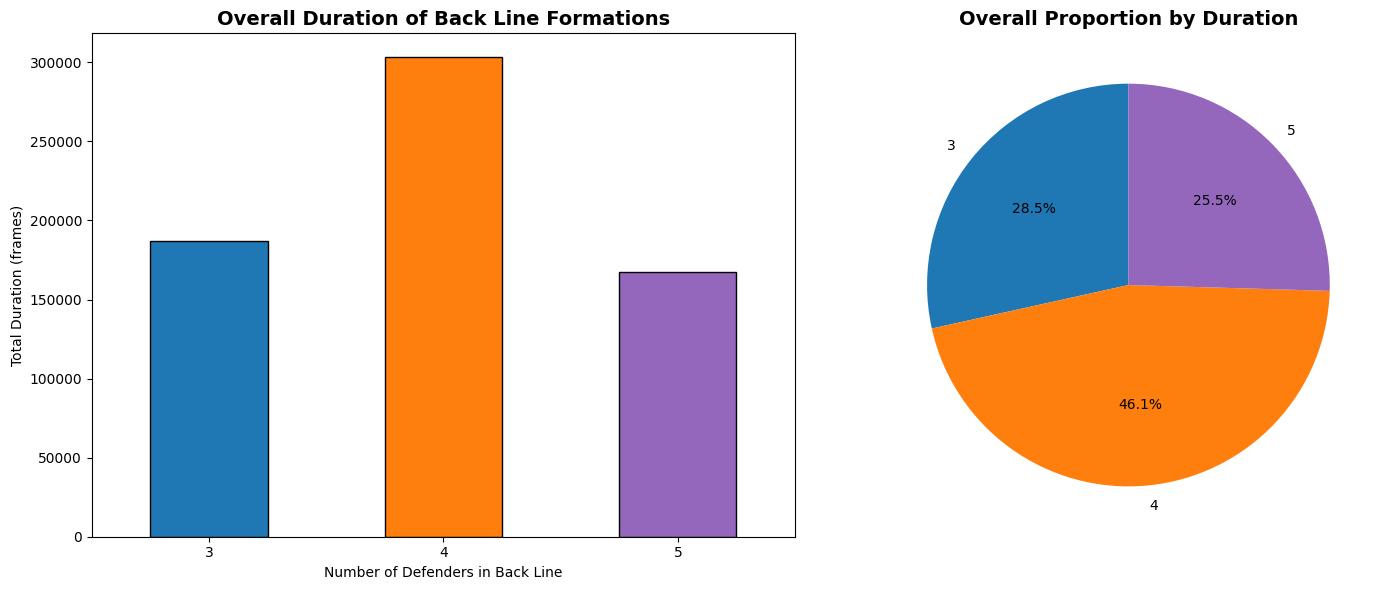

In [24]:

def analyze_formation_duration(df):
    if df is None or not all(col in df.columns for col in ['back_line_count', 'team_id', 'frame_start', 'frame_end']):
        print("No data available")
        return


    team_df = df.copy()
    team_df['duration'] = team_df['frame_end'] - team_df['frame_start']

    formation_durations = team_df.groupby('back_line_count')['duration'].sum().sort_index()
    bar_colors = [colors.get(x, '#CCCCCC') for x in formation_durations.index]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    formation_durations.plot(kind='bar', ax=ax1, color=bar_colors, edgecolor='black')
    ax1.set_title(f'Overall Duration of Back Line Formations', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Defenders in Back Line')
    ax1.set_ylabel('Total Duration (frames)')
    ax1.tick_params(axis='x', rotation=0)

    formation_durations.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, colors=bar_colors)
    ax2.set_title(f'Overall Proportion by Duration', fontsize=14, fontweight='bold')
    ax2.set_ylabel('')

    plt.tight_layout()
    plt.show()



analyze_formation_duration(possessions_analysis)

### Possession Analysis

#### xThreat distribution for formations

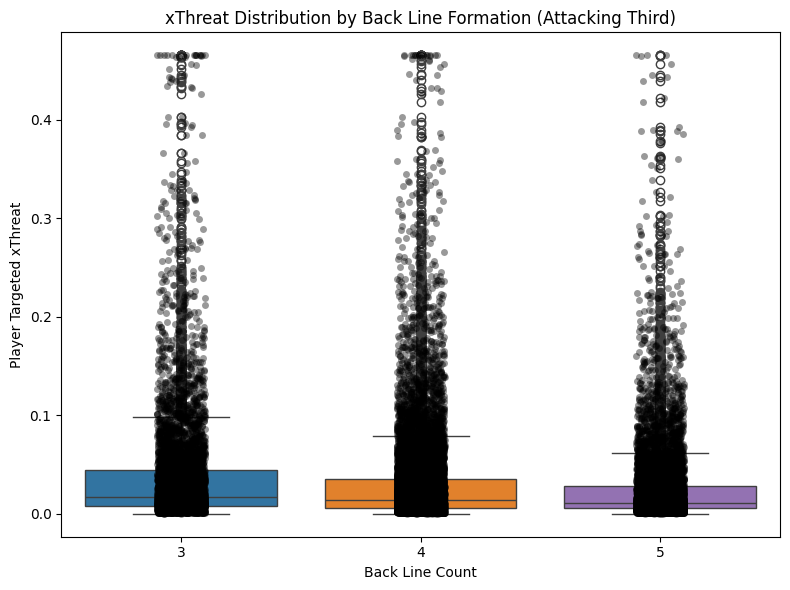

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=possessions_analysis, 
    x="back_line_count", 
    y="player_targeted_xthreat", 
    palette=colors_str
)
sns.stripplot(
    data=possessions_analysis, 
    x="back_line_count", 
    y="player_targeted_xthreat", 
    color="black", 
    alpha=0.4
)
plt.title("xThreat Distribution by Back Line Formation (Attacking Third)")
plt.xlabel("Back Line Count")
plt.ylabel("Player Targeted xThreat")
plt.tight_layout()
plt.show()


#### Shot and Goal Conversion

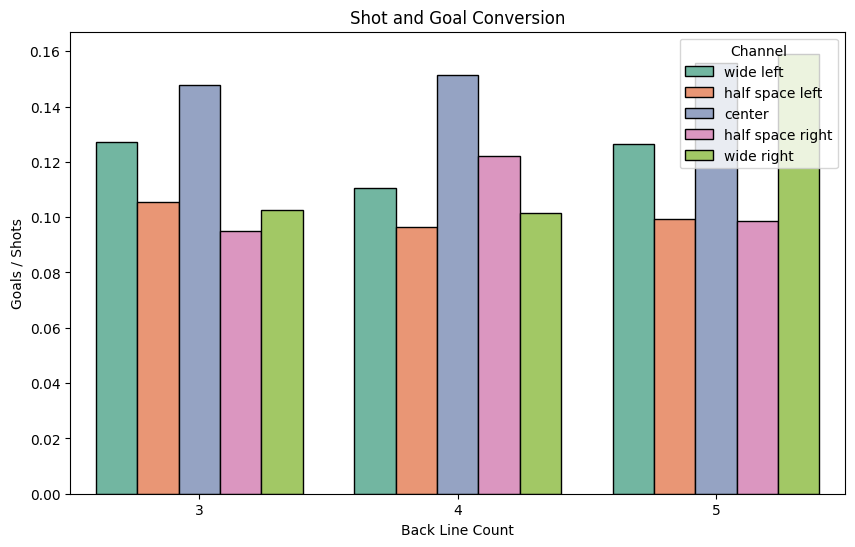

In [26]:
conversion = (
    possessions_analysis
    .groupby(["back_line_count", "channel_end"])
    .agg(
        total_shots=("lead_to_shot", "sum"),
        total_goals=("lead_to_goal", "sum")
    )
    .reset_index()
)

conversion["goal_per_shot"] = conversion["total_goals"] / conversion["total_shots"]

conversion["goal_per_shot"] = conversion["goal_per_shot"].fillna(0)
temp_df = conversion.copy()
temp_df['channel_end'] = temp_df['channel_end'].str.replace('_',' ')

plt.figure(figsize=(10,6))
sns.barplot(
    data=temp_df,
    x="back_line_count",
    y="goal_per_shot",
    hue="channel_end",
    hue_order=channel_order_formatted,
    palette="Set2",
    ci=None,
    edgecolor="black"
)

plt.title(f"Shot and Goal Conversion")
plt.ylabel("Goals / Shots")
plt.xlabel("Back Line Count")
plt.legend(title="Channel")
plt.show()


#### xThreat across fomations and zones

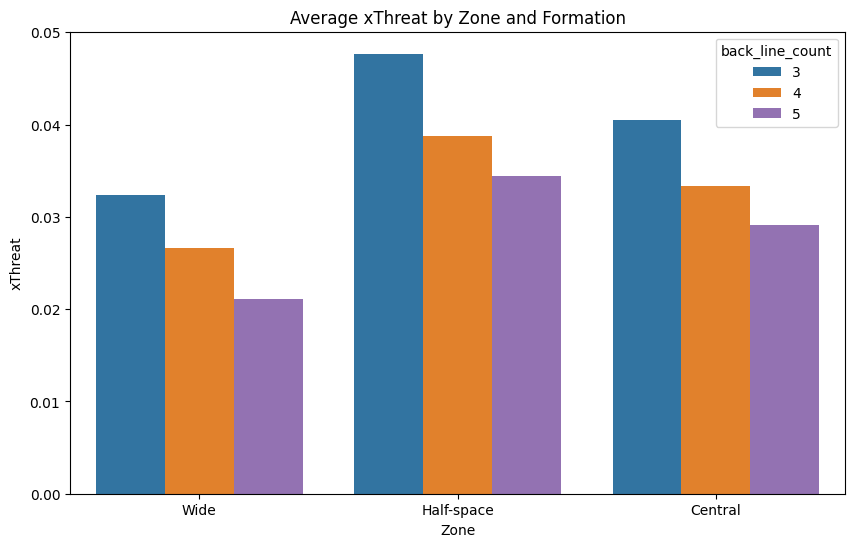

In [27]:
def classify_channel(c):
    if c in ['wide_right','wide_left']:  
        return "Wide"
    elif c in ['half_space_right','half_space_left']:  
        return "Half-space"
    else:
        return "Central"


possessions_analysis["zone"] = possessions_analysis["channel_start"].apply(classify_channel)

plt.figure(figsize=(10,6))
# sns.barplot(data=possessions_analysis, x="zone", y="player_targeted_xthreat",
#             hue="back_line_count", ci=None, palette="muted")
sns.barplot(data=possessions_analysis, x="zone", y="player_targeted_xthreat",
            hue="back_line_count", ci=None, palette=colors, order=classified_channel_order)
plt.title("Average xThreat by Zone and Formation")
plt.ylabel("xThreat")
plt.xlabel("Zone")
plt.show()

### xThreat across Phase Type and formations

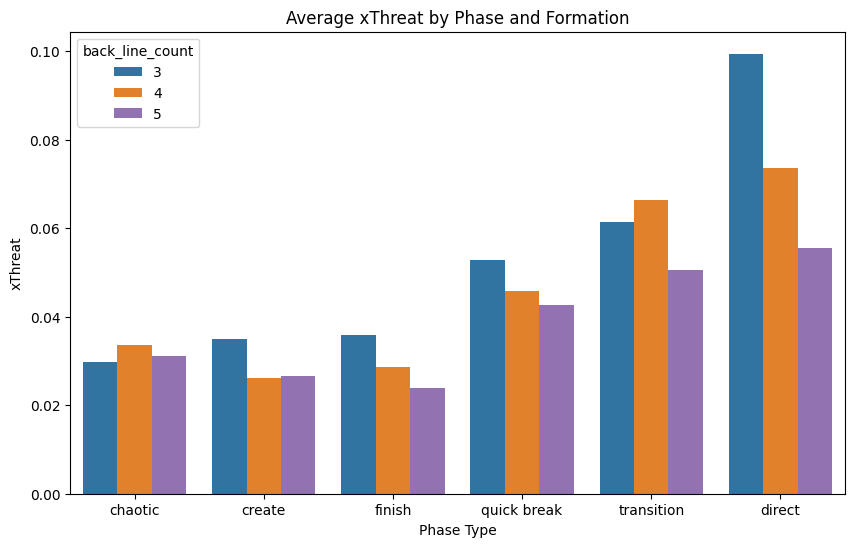

In [28]:

temp_df = possessions_analysis.copy()
temp_df['team_in_possession_phase_type'] = temp_df['team_in_possession_phase_type'].str.replace('_',' ')
plt.figure(figsize=(10,6))
sns.barplot(data=temp_df, x="team_in_possession_phase_type", y="player_targeted_xthreat",
            hue="back_line_count", ci=None, palette=colors, order = phase_type_order)
plt.title("Average xThreat by Phase and Formation")
plt.ylabel("xThreat")
plt.xlabel("Phase Type")
plt.show()

#### xThreat for each team

['North Carolina Courage, Women', 'Kansas City Current, Women', 'Chicago Red Stars, Women', 'San Diego Wave, Women', 'Racing Louisville FC, Women', 'Houston Dash, Women', 'NJ/NY Gotham FC, Women', 'Angel City FC, Women', 'Portland Thorns FC, Women', 'Washington Spirit, Women', 'OL Reign FC, Women', 'Orlando Pride SC, Women', 'Manchester United, Women', 'Aston Villa, Women', 'Arsenal Football Club, Women', 'Liverpool LFC, Women', 'Tottenham Hotspur, Women', 'Chelsea, Women', 'Manchester City, Women', 'Bristol City WFC, Women', 'West Ham United, Women', 'Brighton and Hove Albion, Women', 'Everton, Women', 'Leicester City, Women']


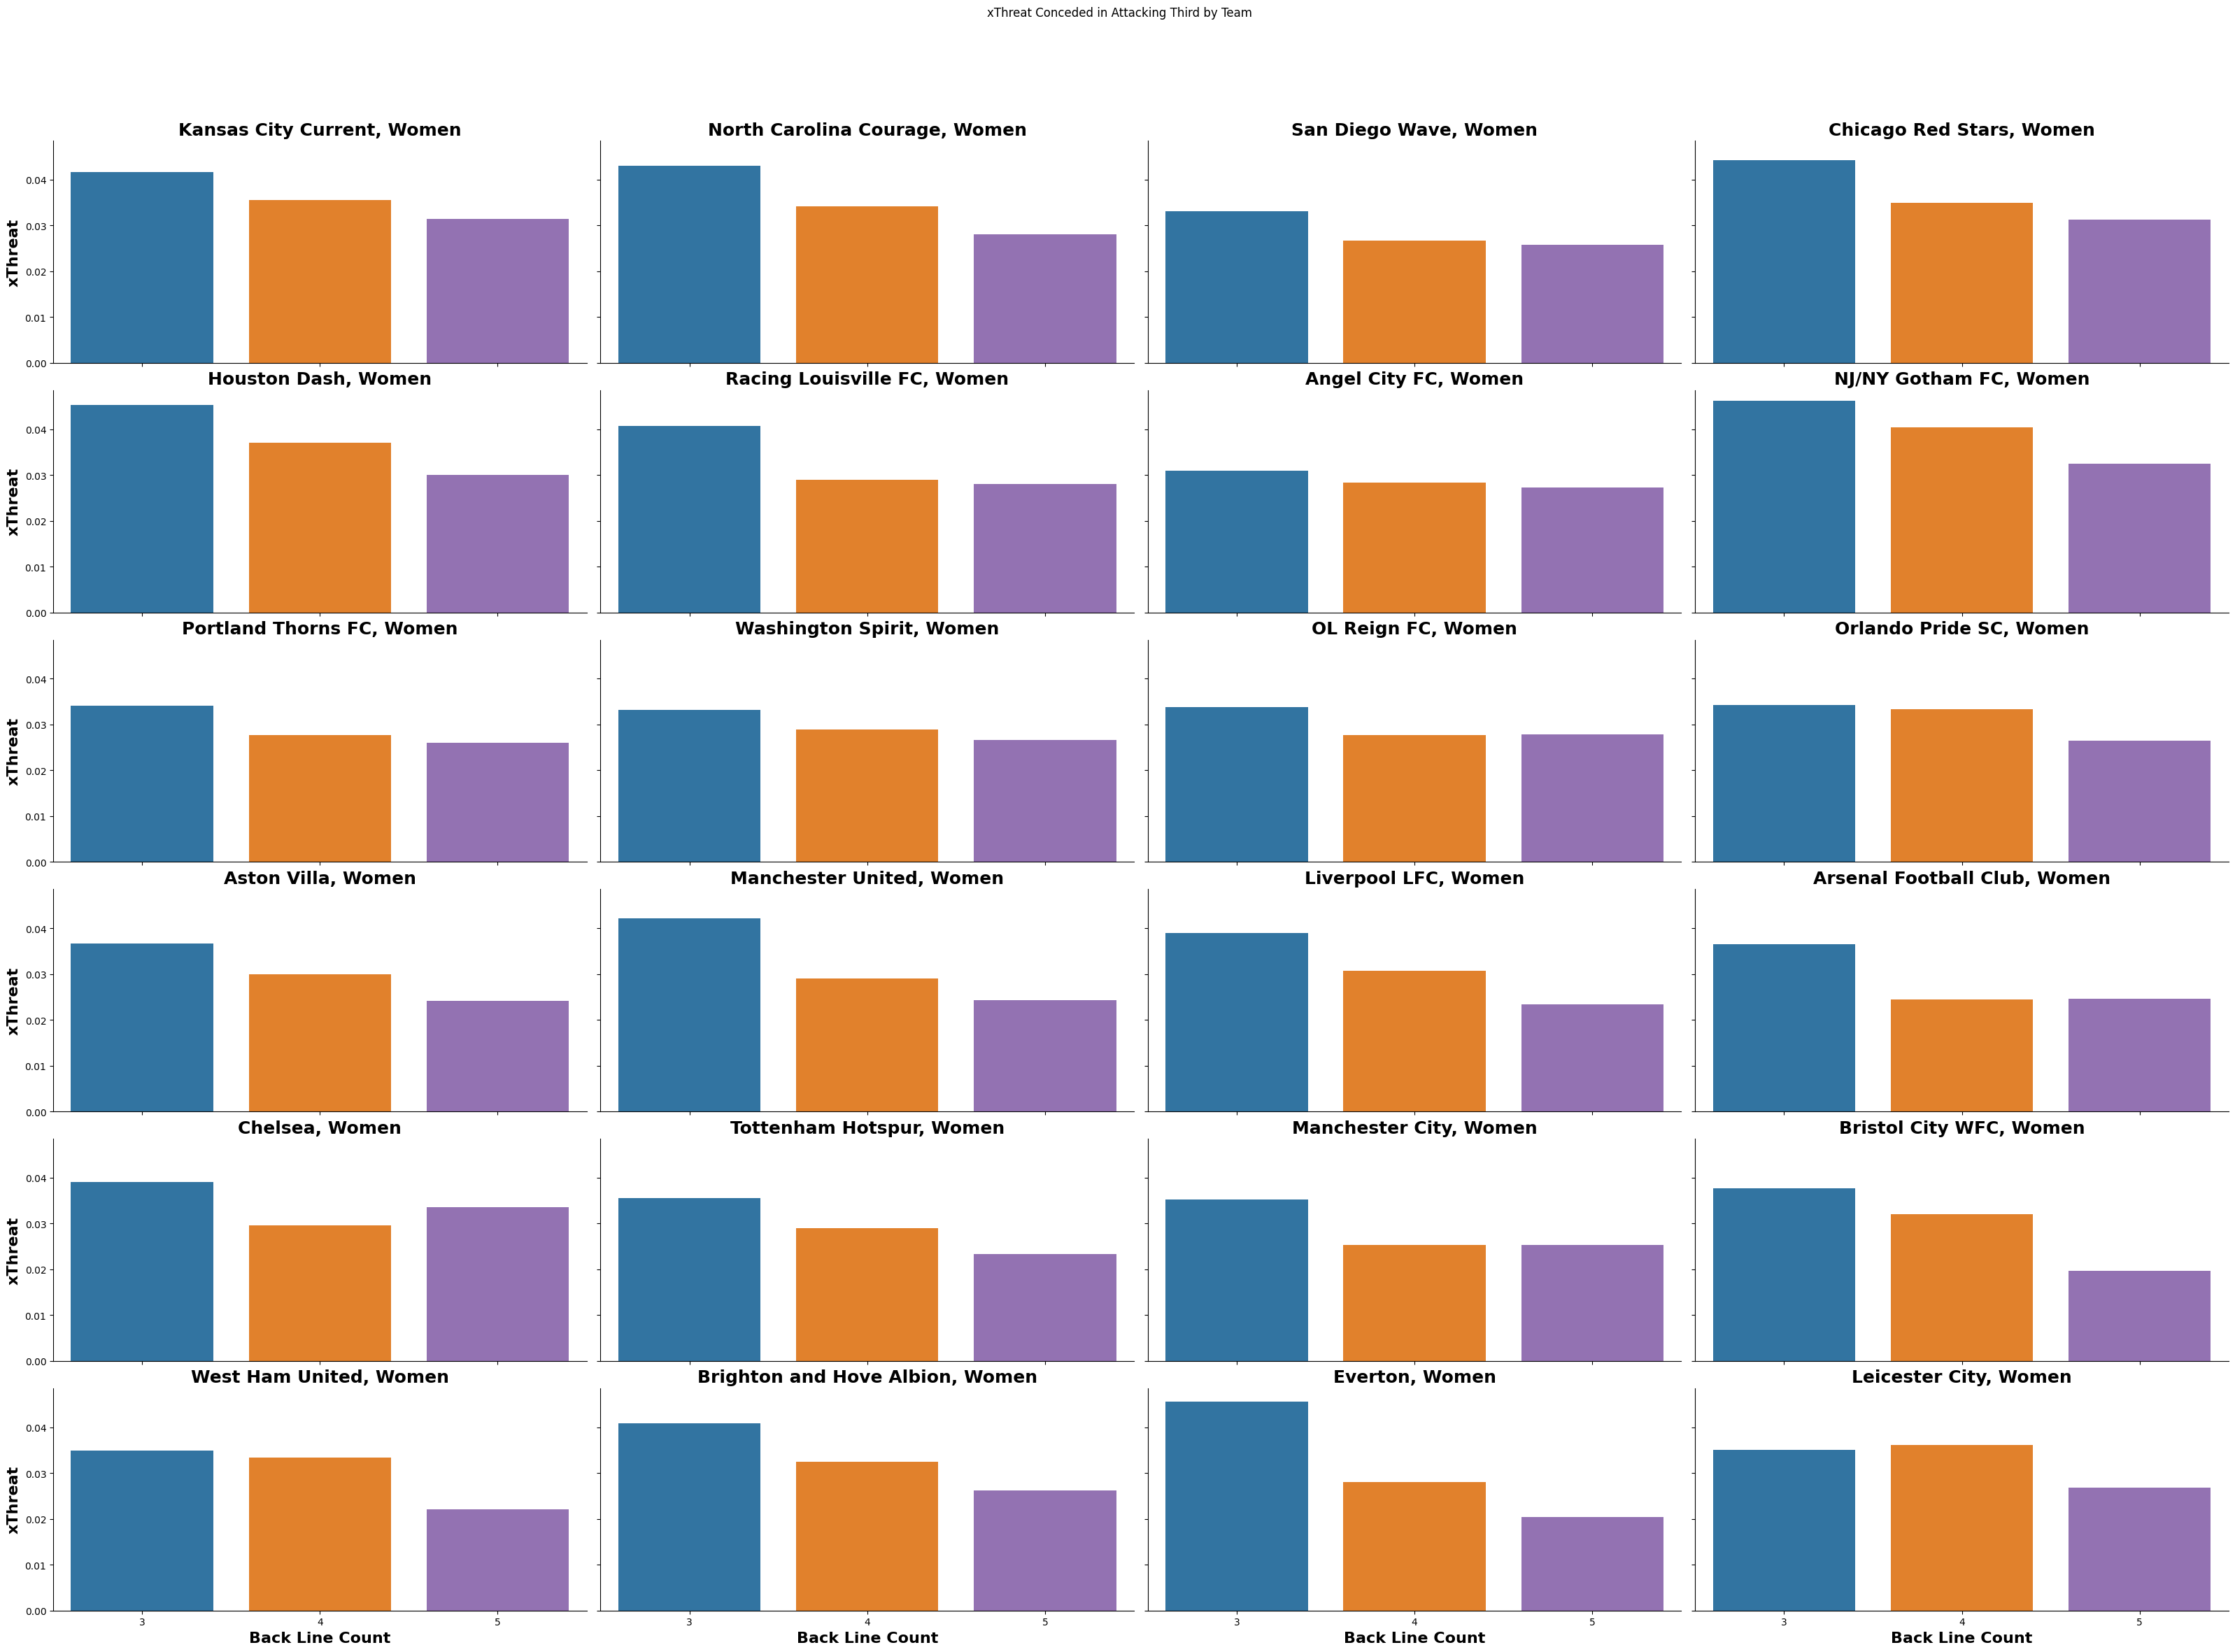

In [29]:
possessions_analysis['team_name'] = possessions_analysis['team_id'].map(team_mapping)
print(possessions_analysis['team_name'].unique().tolist())
g = sns.catplot(
    data=possessions_analysis,
    x="back_line_count",
    y="player_targeted_xthreat",
    col="opponent_name",
    kind="bar",
    ci=None,
    palette=colors_str,
    col_wrap=4,
    height=4, aspect=2
)
g.set_axis_labels("Back Line Count", "xThreat", fontsize=16, fontweight="bold")
g.set_xlabels("Back Line Count", fontsize=16, fontweight="bold")
g.set_ylabels("xThreat", fontsize=16, fontweight="bold")

g.set_titles("{col_name}")
g.set_axis_labels("Back Line Count", "xThreat")
plt.subplots_adjust(top=0.9)
g.set_titles("{col_name}", size=18, fontweight="bold")
g.fig.suptitle("xThreat Conceded in Attacking Third by Team")
plt.show()

### Line breaks vs. formation (by channel)

In [34]:
temp_merged_df = passing_offball_merged.copy()
temp_merged_df['channel_start_x'] = temp_merged_df['channel_start_x'].str.replace('_',' ')
temp_merged_df['channel_end_x'] = temp_merged_df['channel_end_x'].str.replace('_',' ')

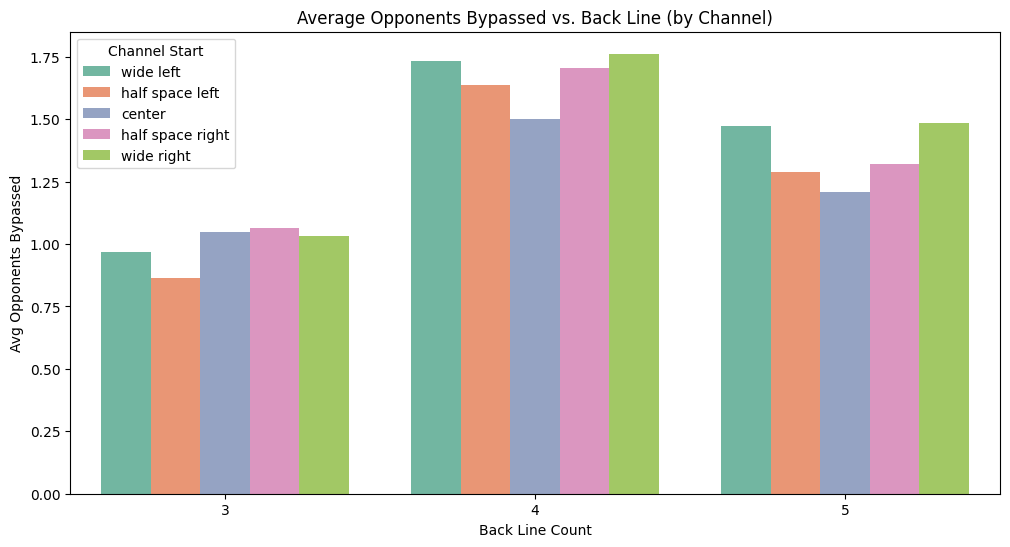

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=temp_merged_df,
    x="back_line_count", 
    y="n_opponents_bypassed", 
    hue="channel_start_x", 
    order=possessions_order,
    hue_order=channel_order_formatted,
    estimator="mean",
    errorbar=None,
    palette="Set2"
)
plt.title("Average Opponents Bypassed vs. Back Line (by Channel)")
plt.ylabel("Avg Opponents Bypassed")
plt.xlabel("Back Line Count")
plt.legend(title="Channel Start")
plt.show()

### xpass vs formation with Channel

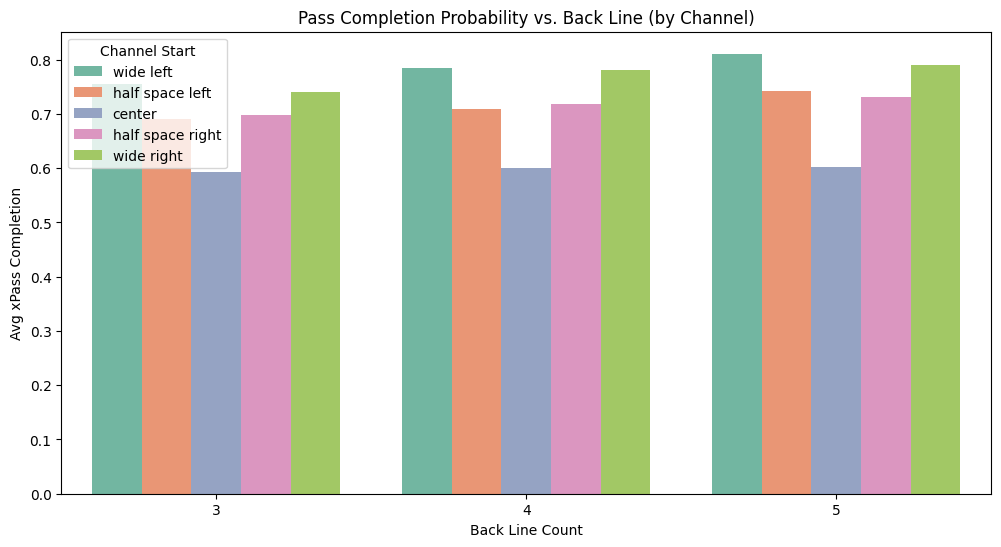

In [36]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=temp_merged_df,
    x="back_line_count", 
    y="xpass_completion", 
    hue="channel_start_x", 
    order=possessions_order,
    hue_order=channel_order_formatted,
    estimator="mean",
    errorbar=None,
    palette="Set2"
)
plt.title("Pass Completion Probability vs. Back Line (by Channel)")
plt.ylabel("Avg xPass Completion")
plt.xlabel("Back Line Count")
plt.legend(title="Channel Start")
plt.show()


### Dangerous pass frequency vs. formation (by channel)

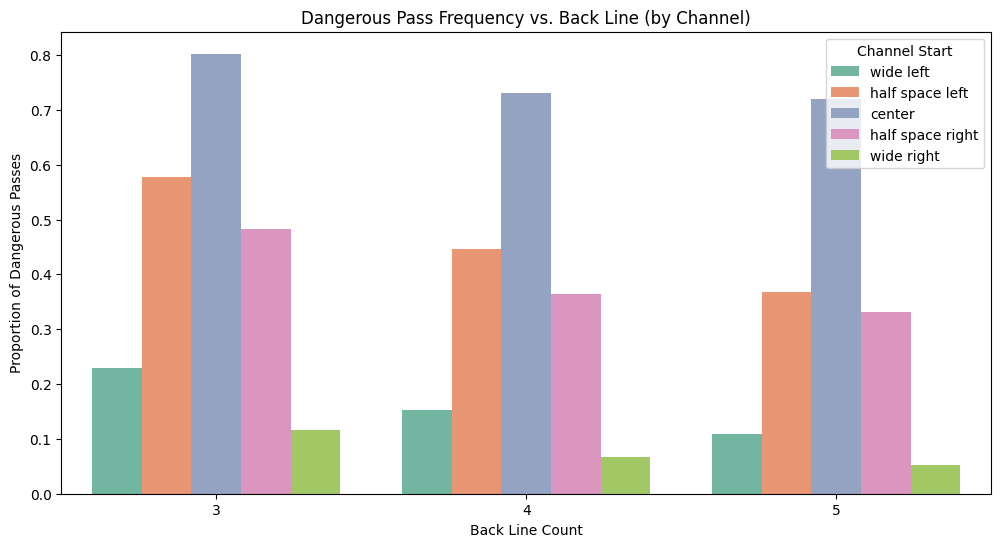

In [37]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=temp_merged_df,
    x="back_line_count", 
    y="dangerous_x", 
    hue="channel_start_x", 
    order=possessions_order,
    hue_order=channel_order_formatted,
    estimator="mean",
    errorbar=None,
    palette="Set2"
)
plt.title("Dangerous Pass Frequency vs. Back Line (by Channel)")
plt.ylabel("Proportion of Dangerous Passes")
plt.xlabel("Back Line Count")
plt.legend(title="Channel Start")
plt.show()

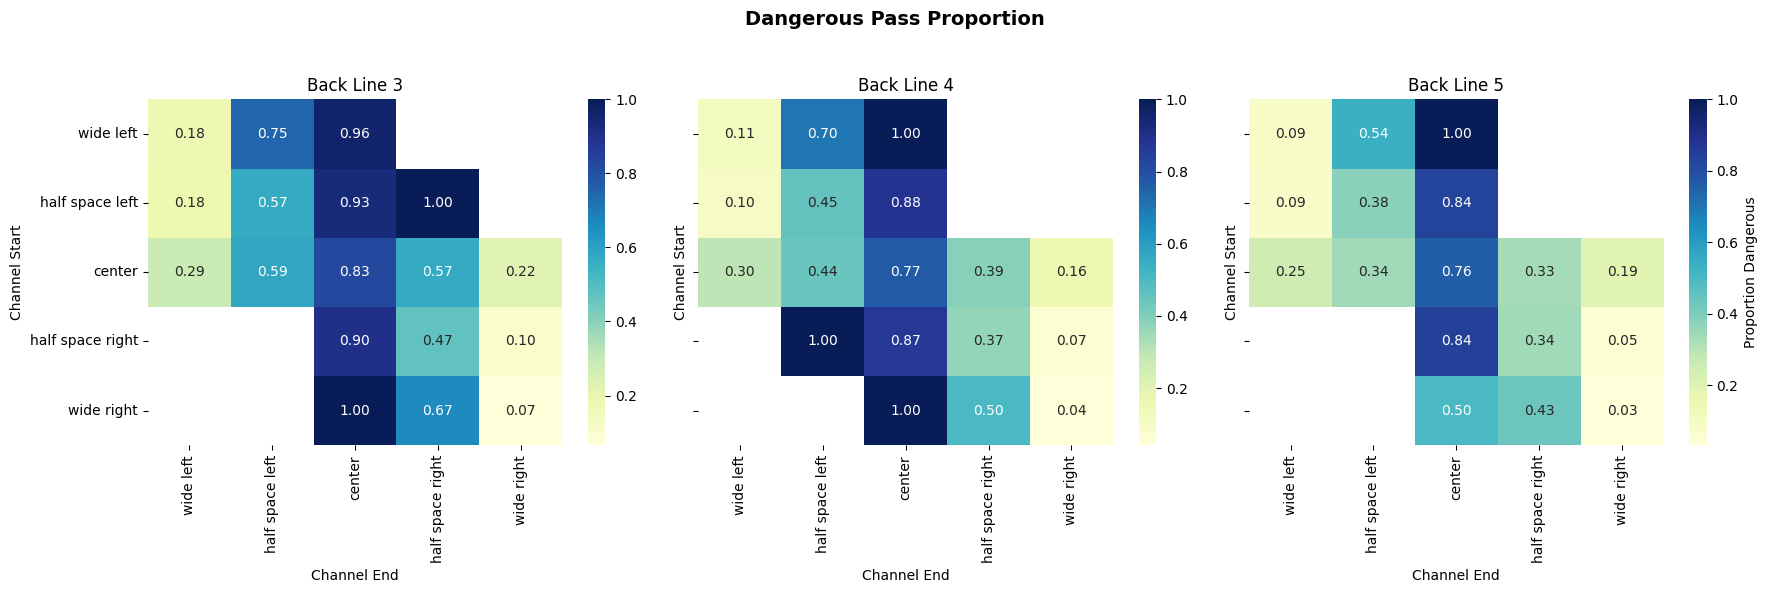

In [39]:
# for blc in passing_offball_merged['back_line_count'].unique():
#     subset = passing_offball_merged[passing_offball_merged['back_line_count'] == blc]
#     table = (
#         subset.groupby(['channel_start_x', 'channel_end_x'])['dangerous_x']
#         .mean()
#         .unstack()
#     )
    
#     plt.figure(figsize=(7, 6))
#     sns.heatmap(table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Proportion Dangerous"})
#     plt.title(f'Dangerous Pass Proportion\nBack Line Count {blc}')
#     plt.xlabel("Channel End")
#     plt.ylabel("Channel Start")
#     plt.show()
    

back_line_counts = sorted(temp_merged_df['back_line_count'].dropna().unique())
n = len(back_line_counts)

fig, axes = plt.subplots(1, n, figsize=(6*n, 6), sharex=True, sharey=True)

if n == 1:
    axes = [axes]

for ax, blc in zip(axes, back_line_counts):
    subset = temp_merged_df[temp_merged_df['back_line_count'] == blc]
    
    table = (
        subset.groupby(['channel_start_x', 'channel_end_x'])['dangerous_x']
        .mean()
        .unstack()
        .reindex(index=channel_order_formatted, columns=channel_order_formatted)

    )
    
    sns.heatmap(
        table,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar_kws={"label": "Proportion Dangerous"} if ax == axes[-1] else None
    )
    
    ax.set_title(f"Back Line {blc}")
    ax.set_xlabel("Channel End")
    ax.set_ylabel("Channel Start")
    ax.tick_params(axis='y', rotation=0)

fig.suptitle(
    f"Dangerous Pass Proportion",
    fontsize=14, 
    fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


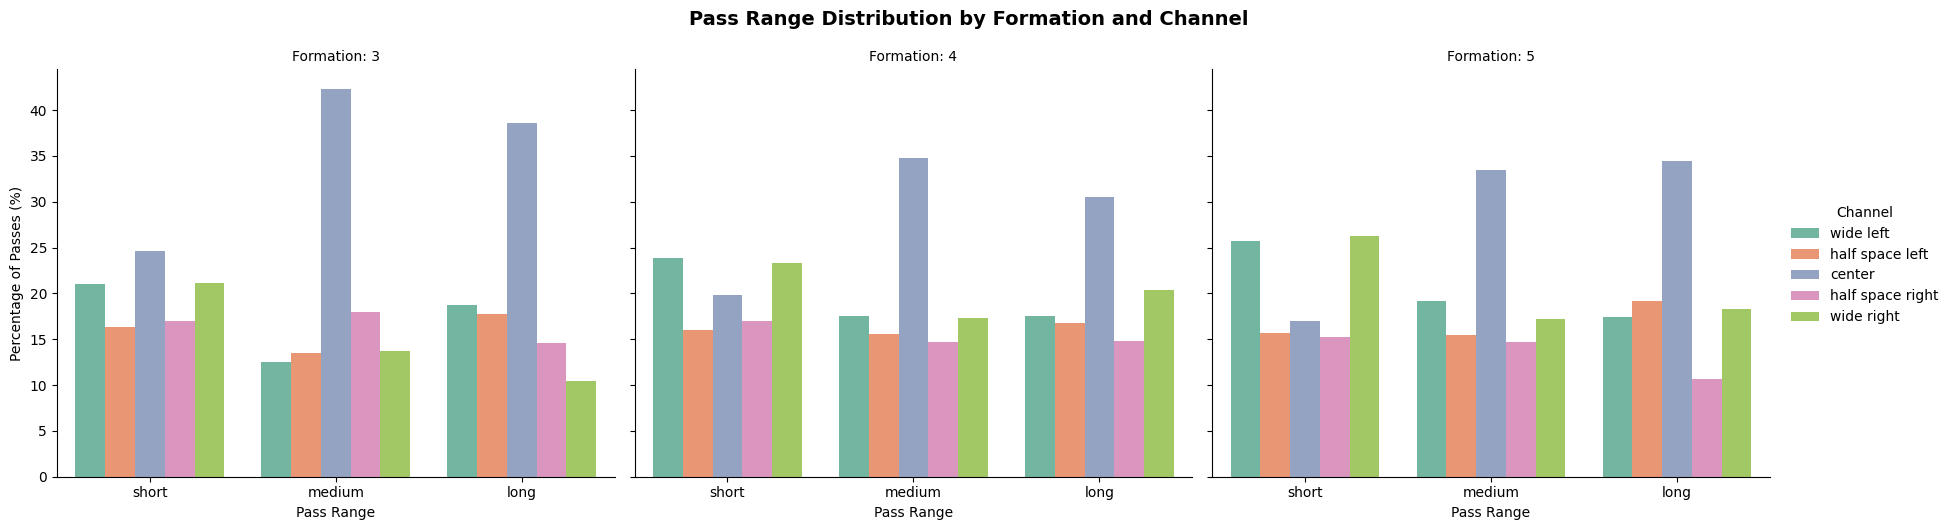

In [40]:
dist = (
    temp_merged_df.groupby(["back_line_count", "channel_start_x", "pass_range"])
    .size()
    .reset_index(name="count")
)

dist["pct"] = dist.groupby(["back_line_count", "pass_range"])["count"].transform(
    lambda x: x / x.sum() * 100
)



g = sns.catplot(
    data=dist,
    x="pass_range",
    y="pct",
    hue="channel_start_x",
    hue_order=channel_order_formatted,
    col="back_line_count",
    kind="bar",
    palette="Set2",
    height=5,
    aspect=1.2,
    order = pass_range_order
)


g.set_axis_labels("Pass Range", "Percentage of Passes (%)")
g.set_titles("Formation: {col_name}")
g._legend.set_title("Channel")
plt.suptitle("Pass Range Distribution by Formation and Channel", y=1.05, fontsize=14, fontweight="bold")
plt.show()

### Teamwise formation distribution and xThreat Conceded

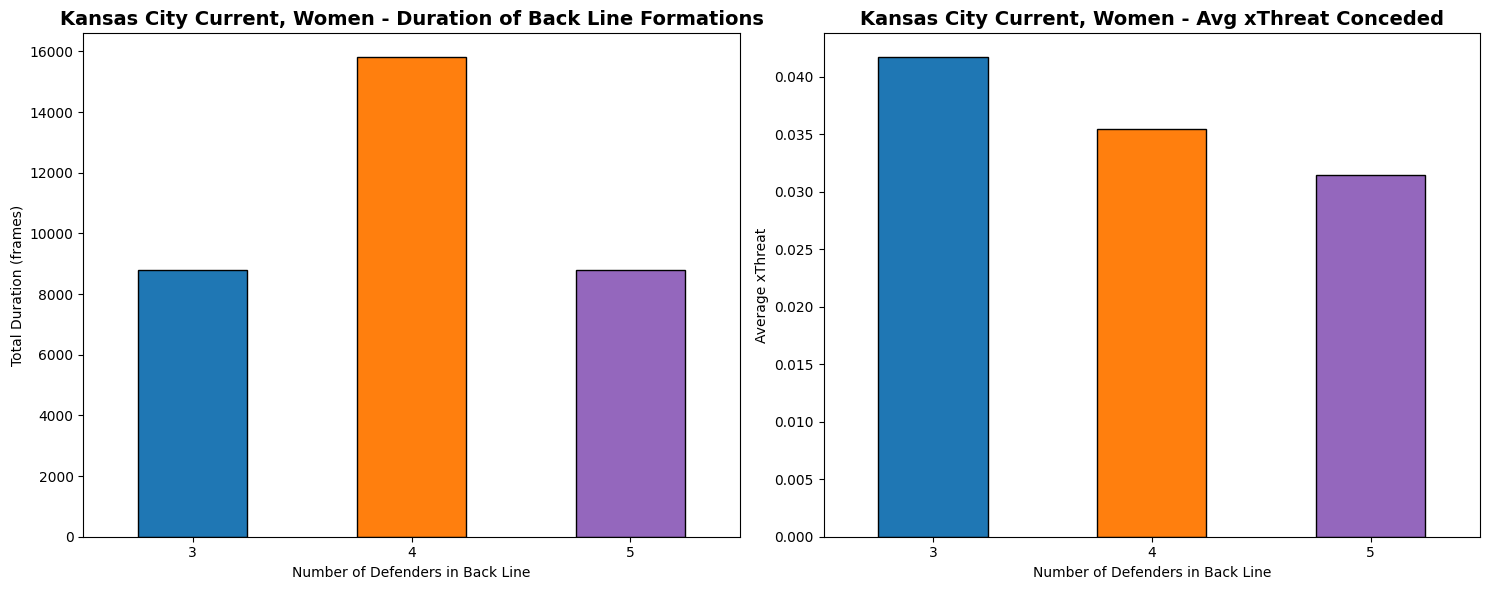

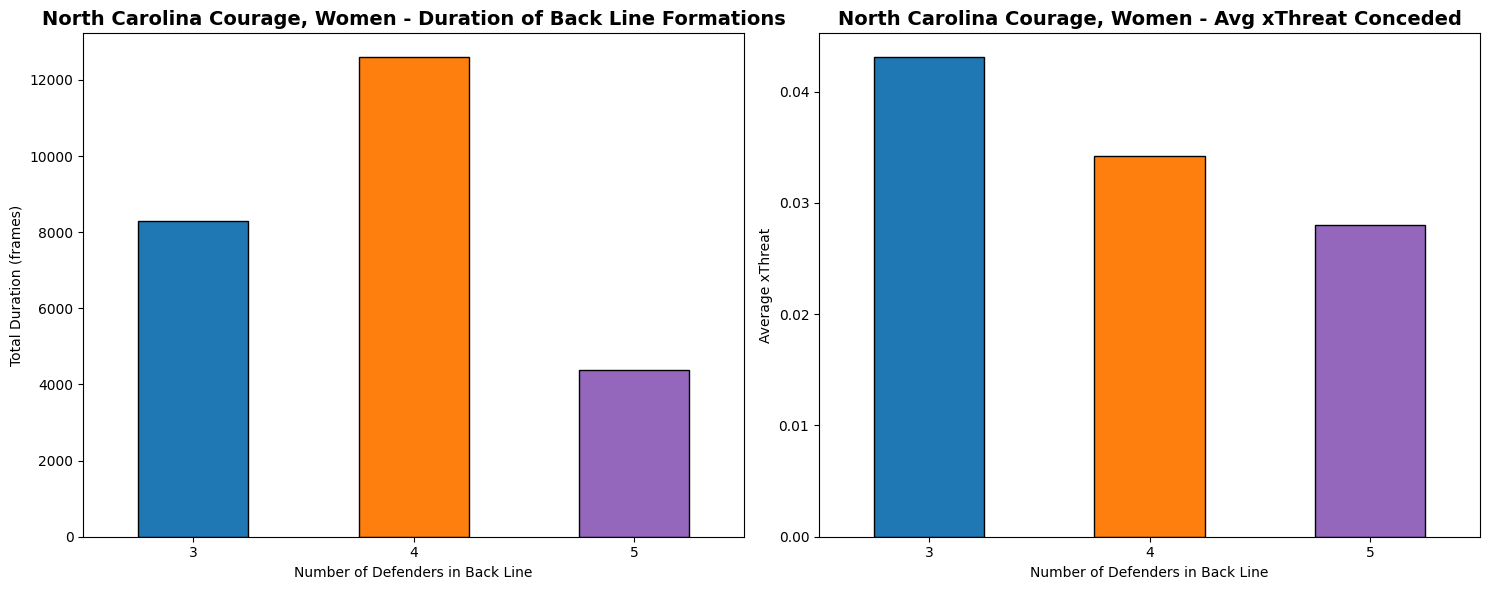

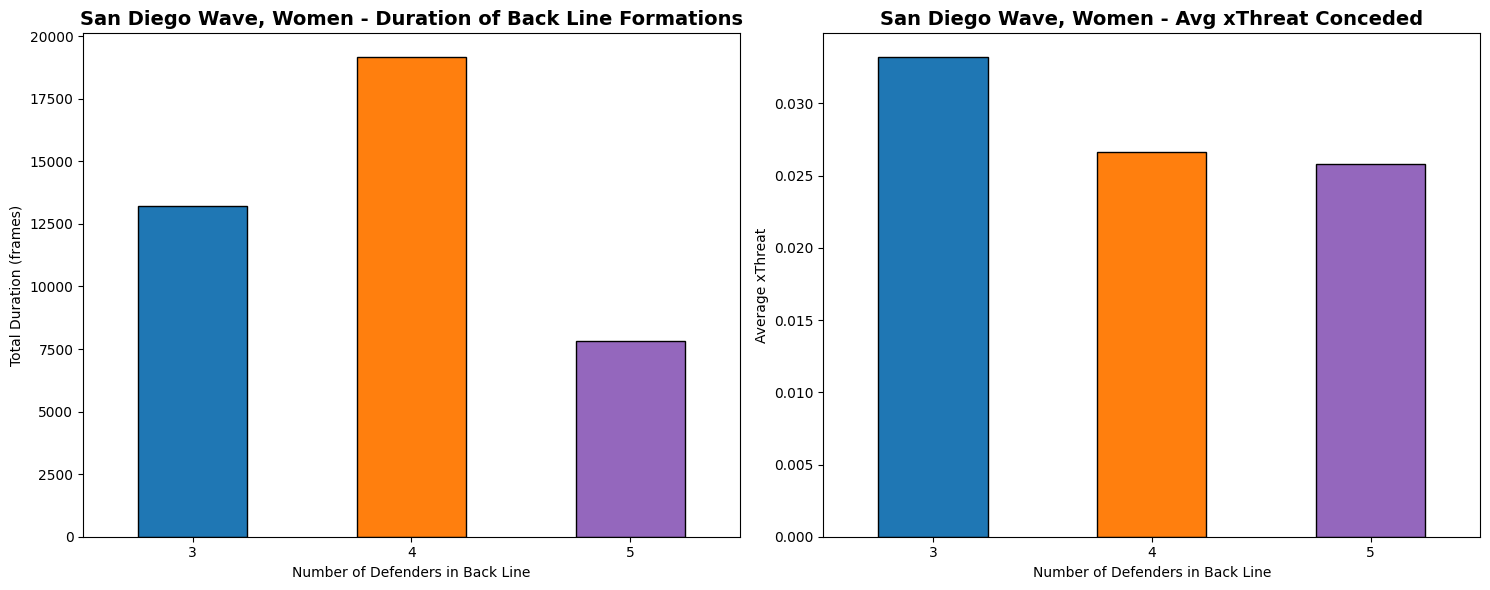

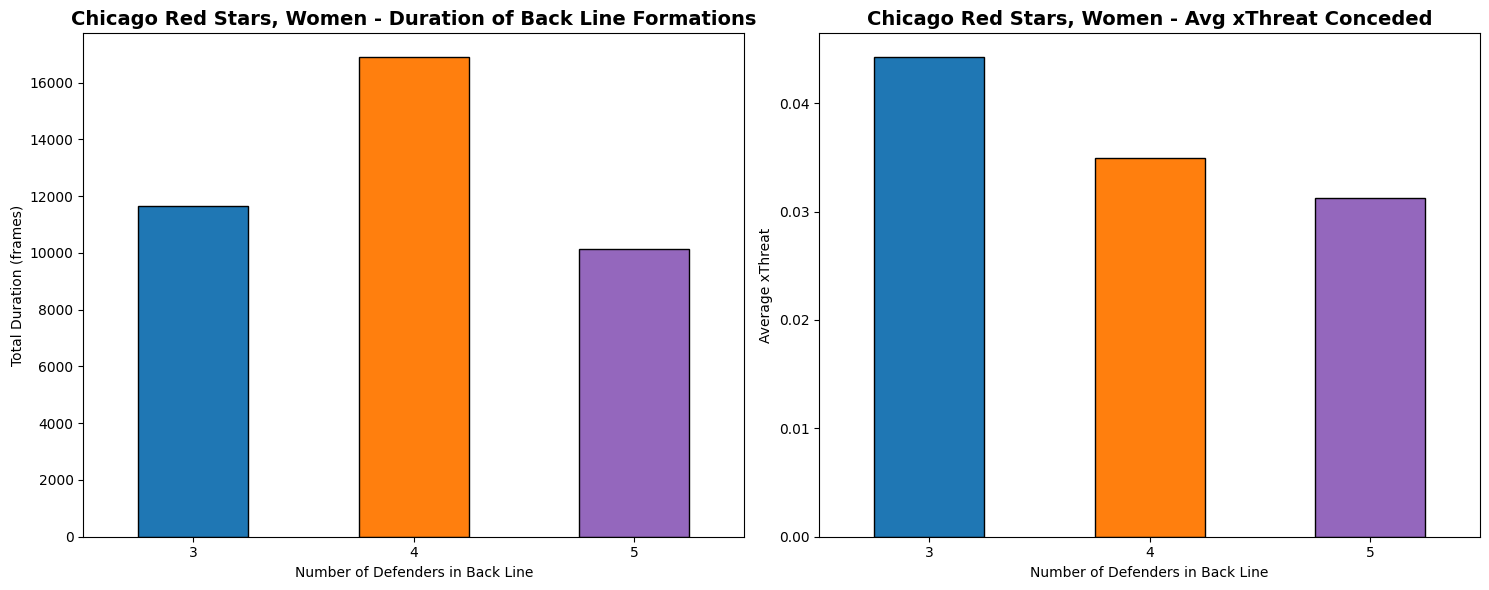

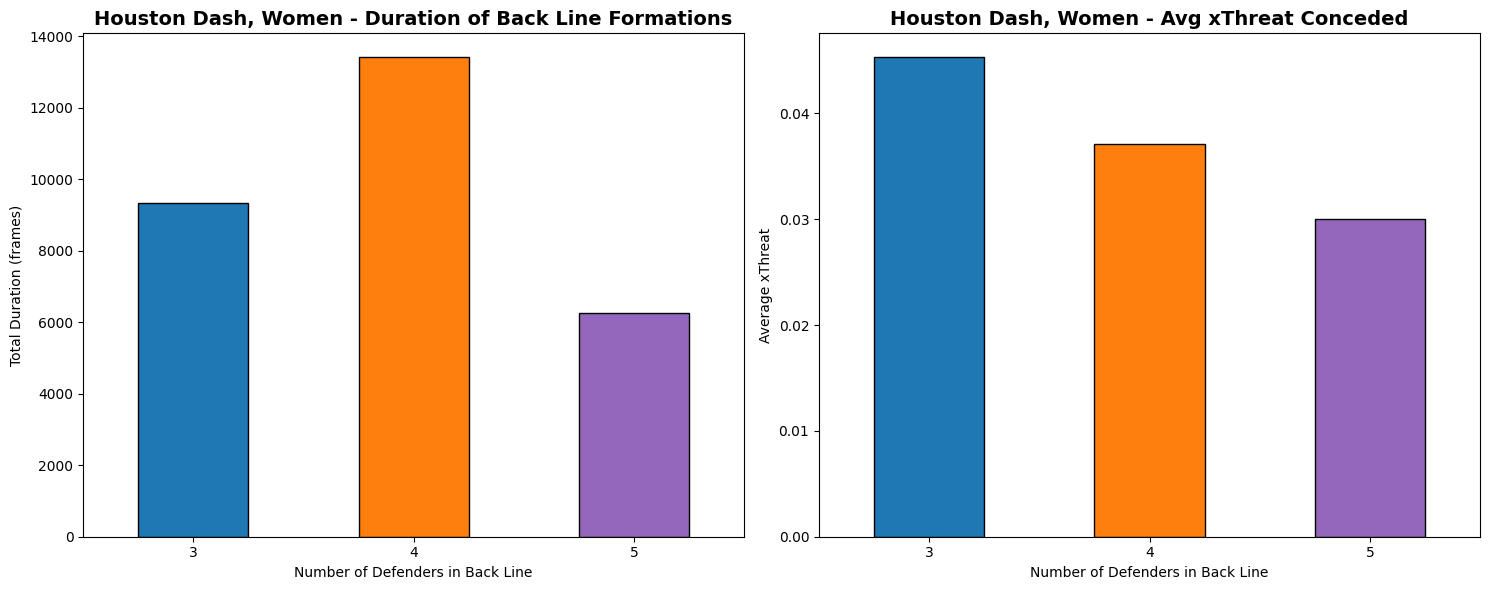

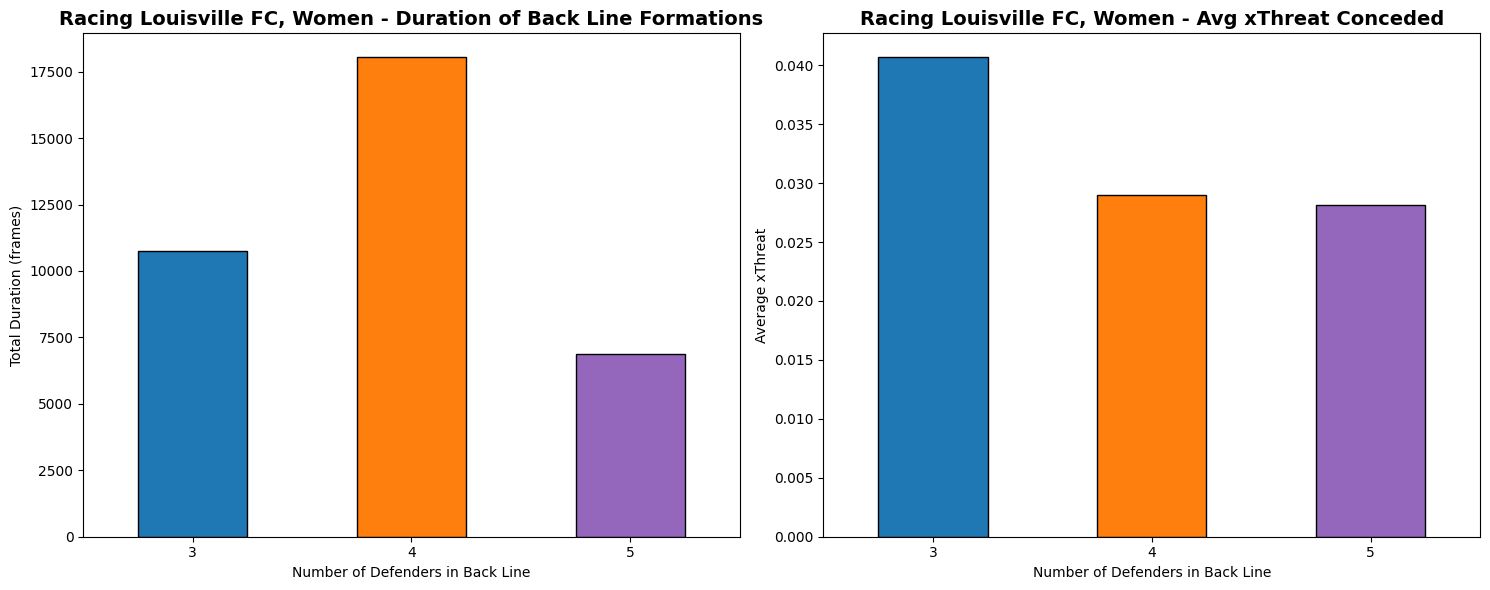

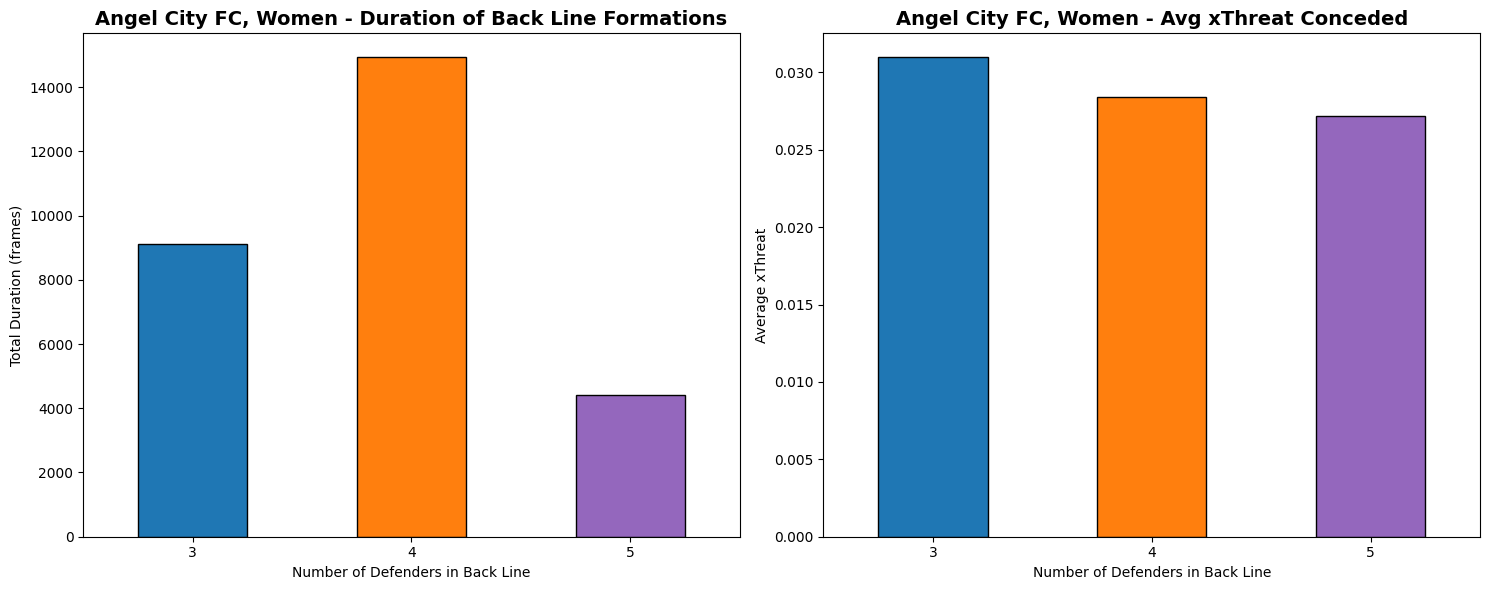

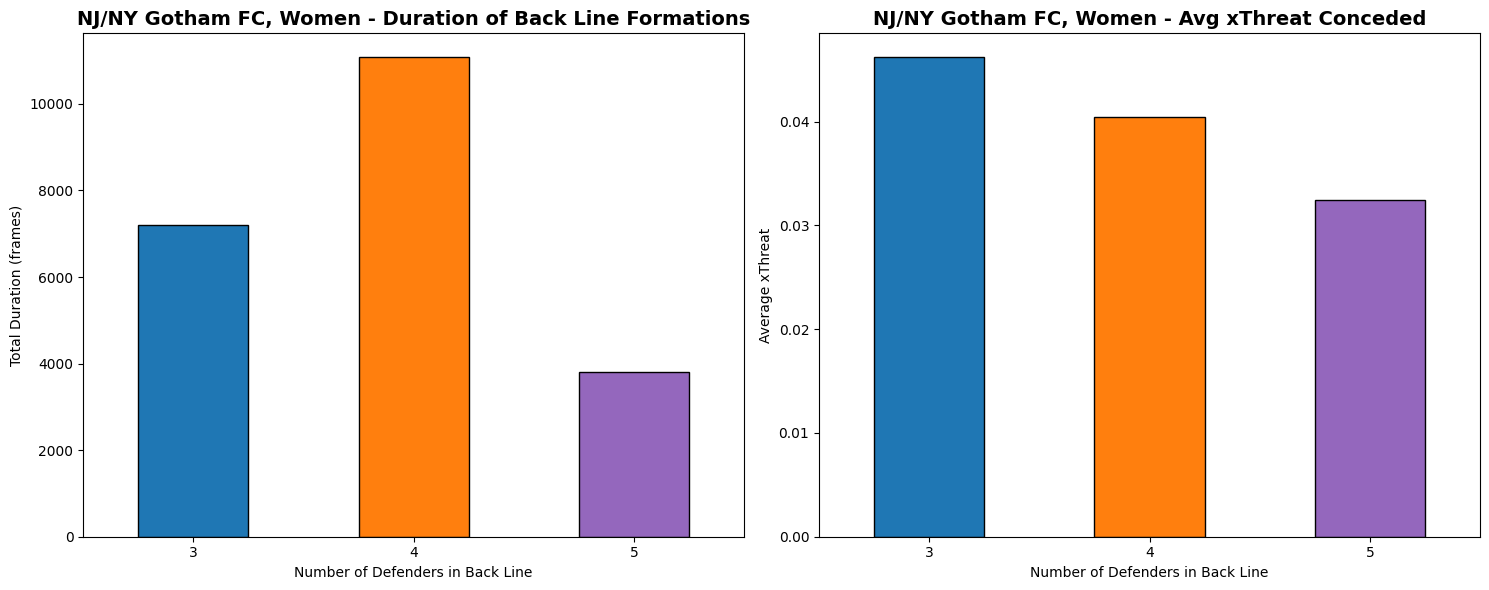

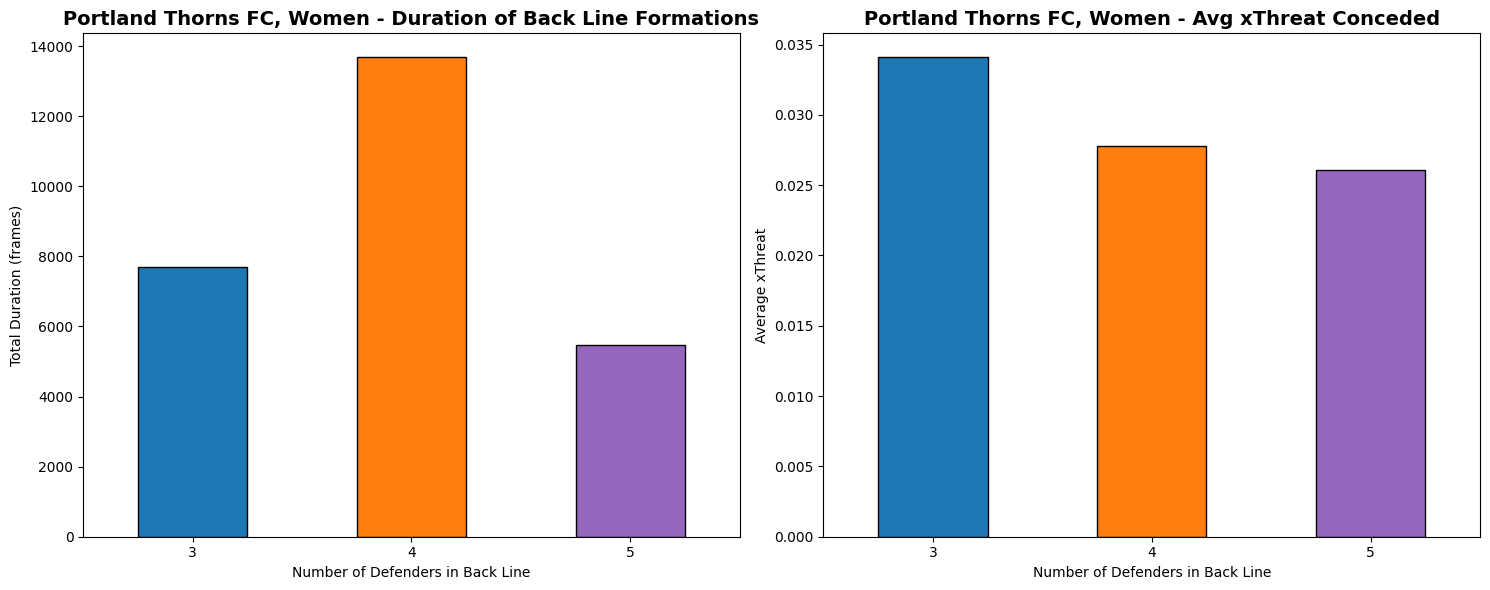

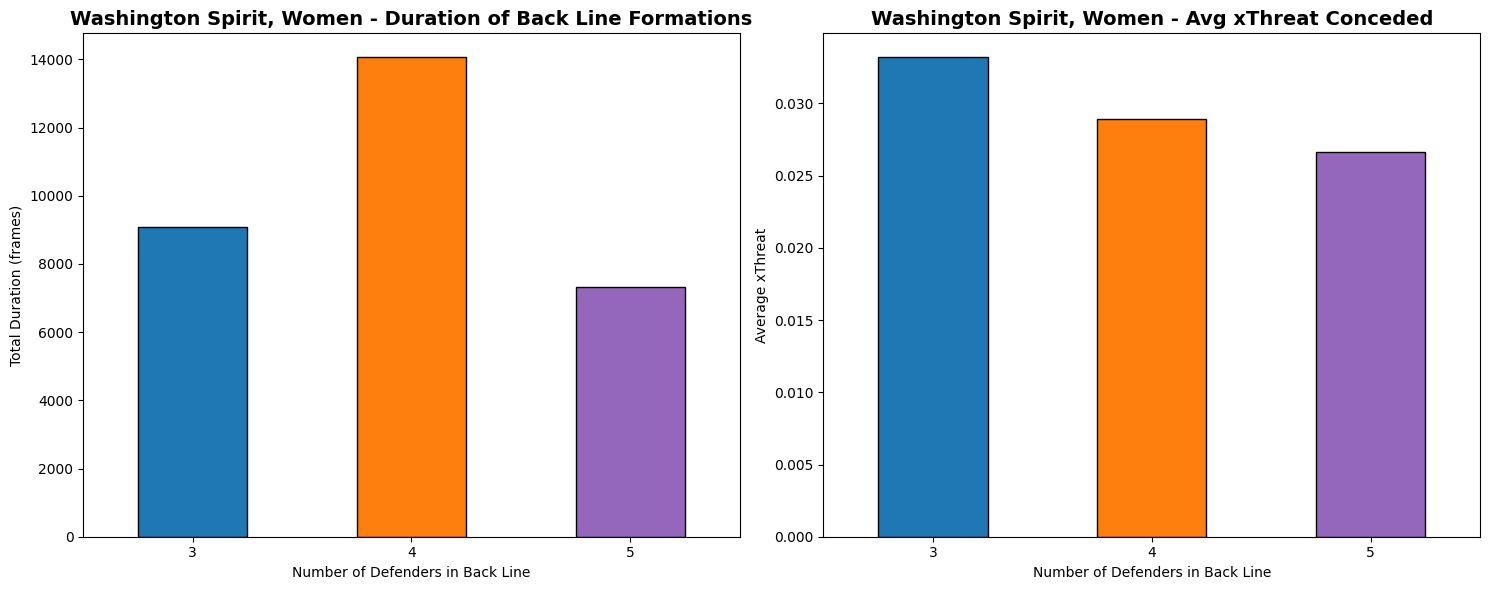

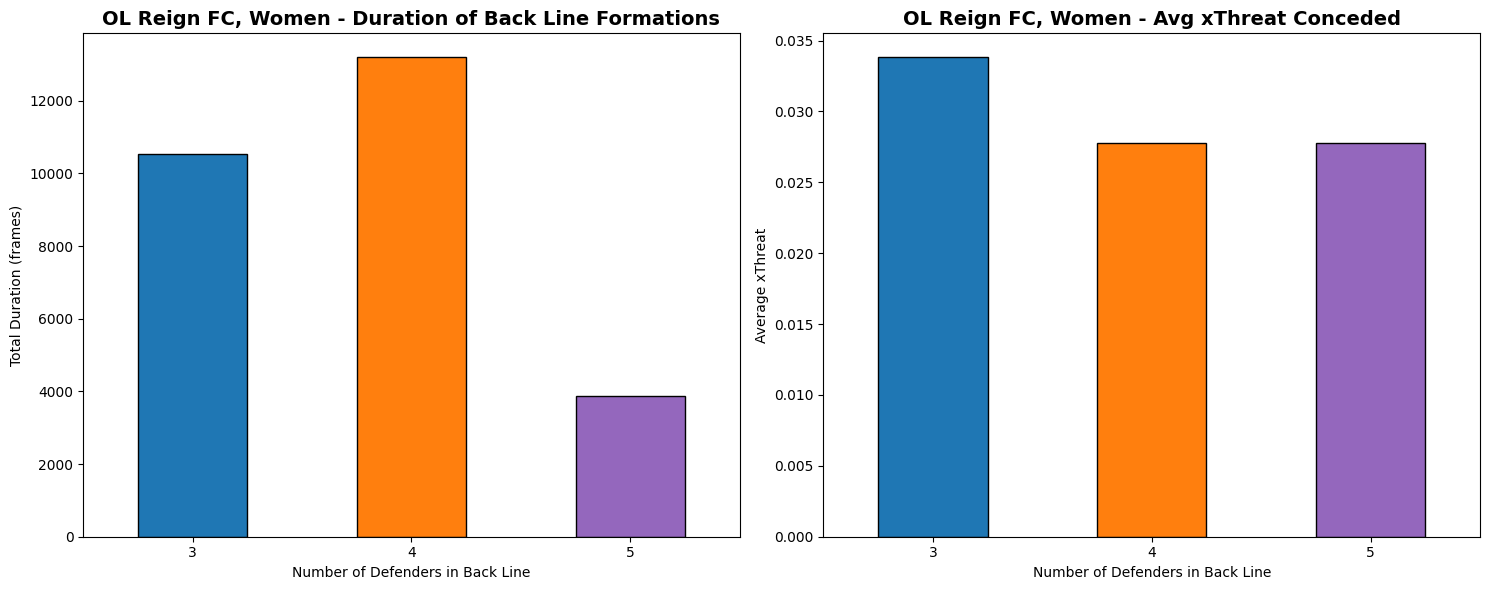

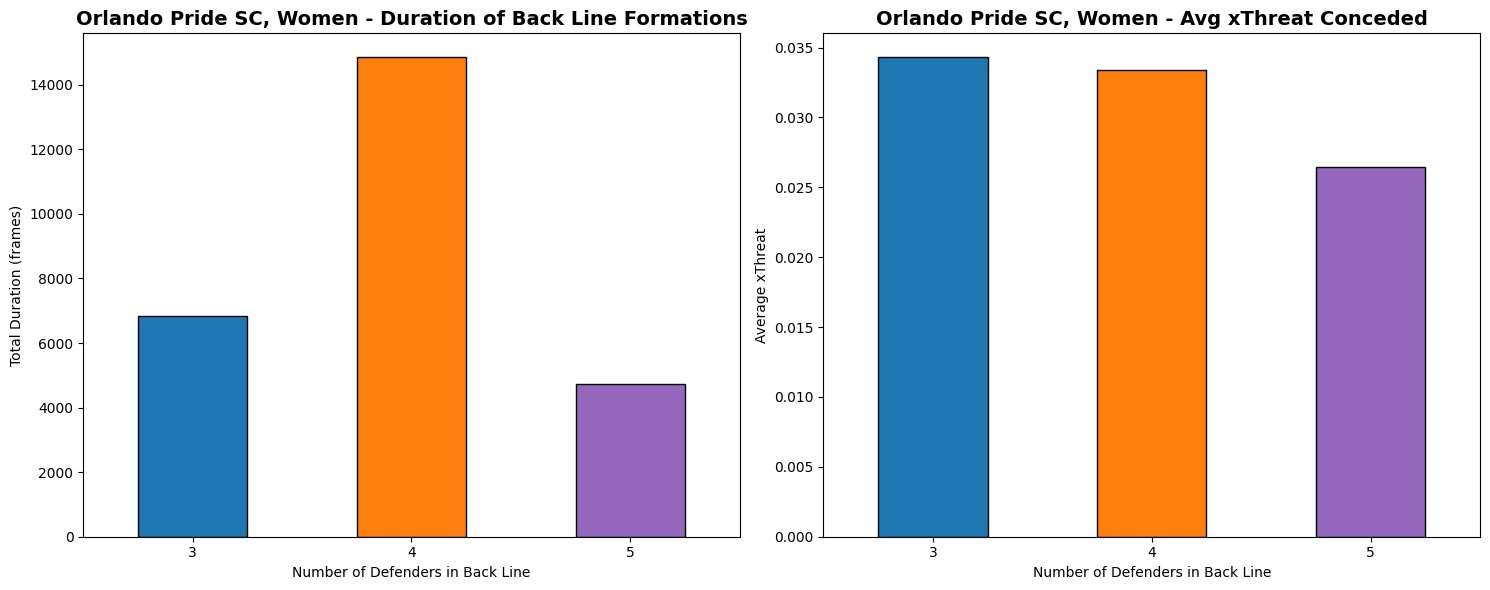

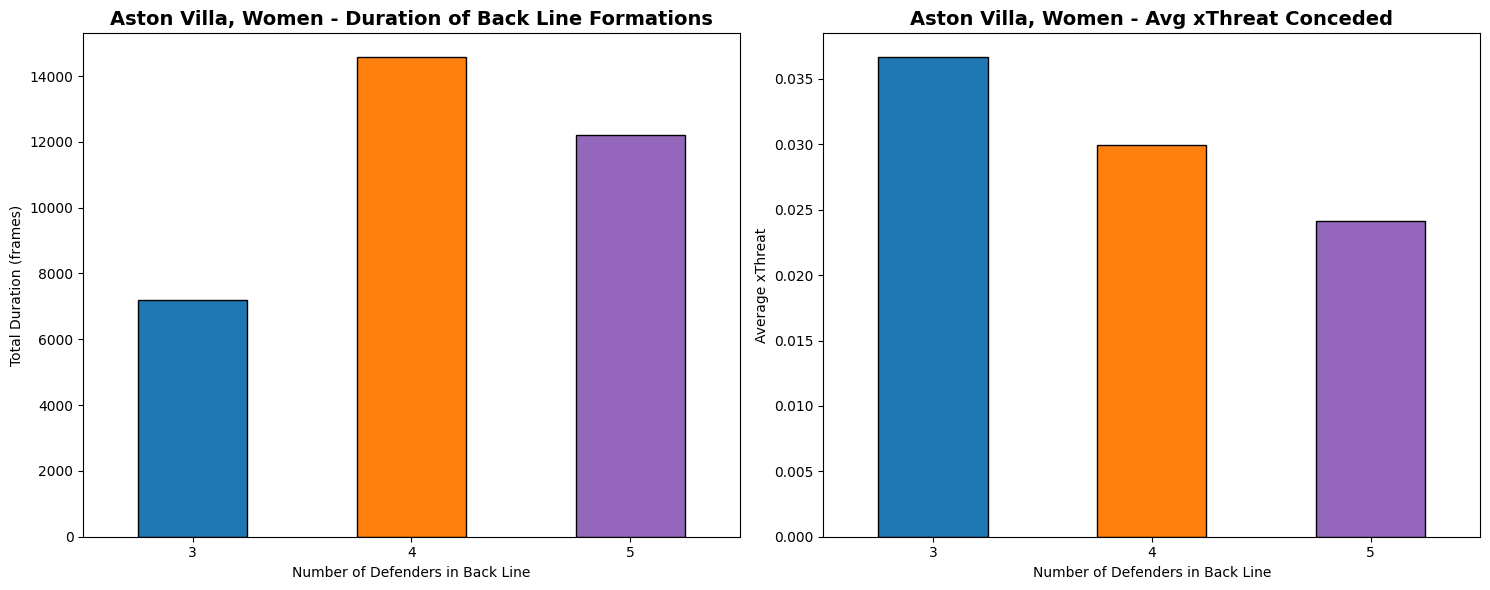

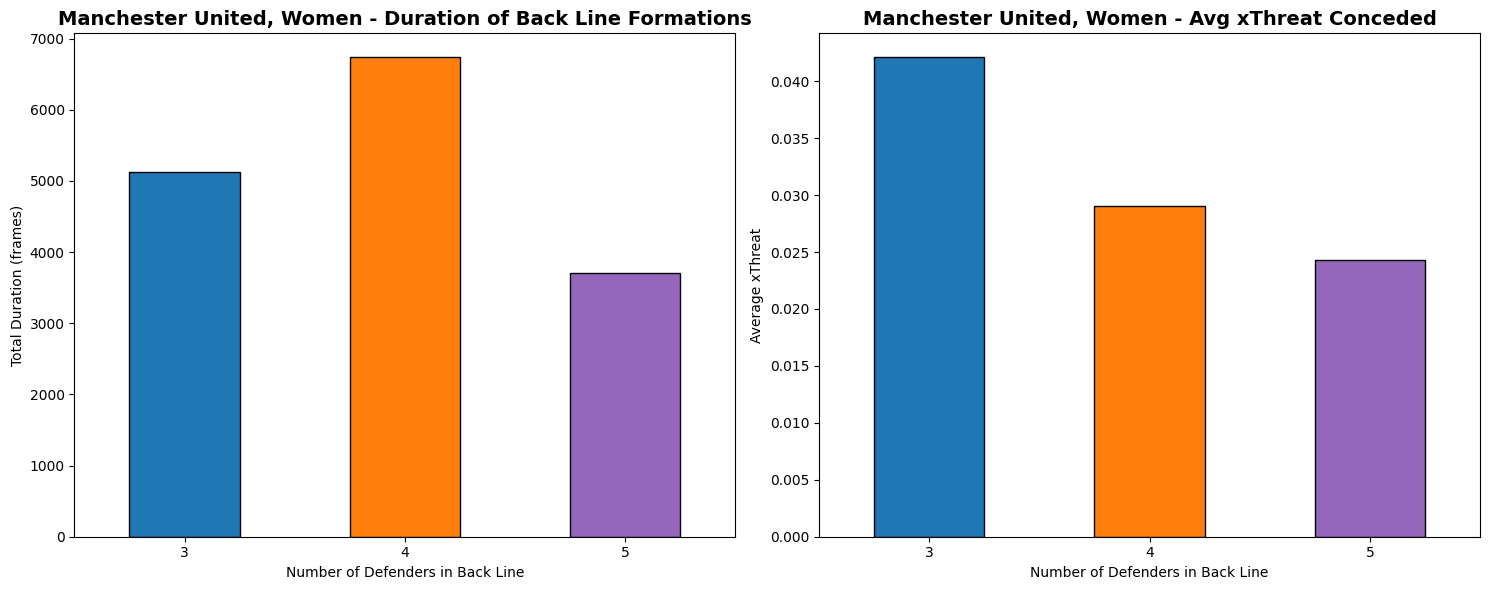

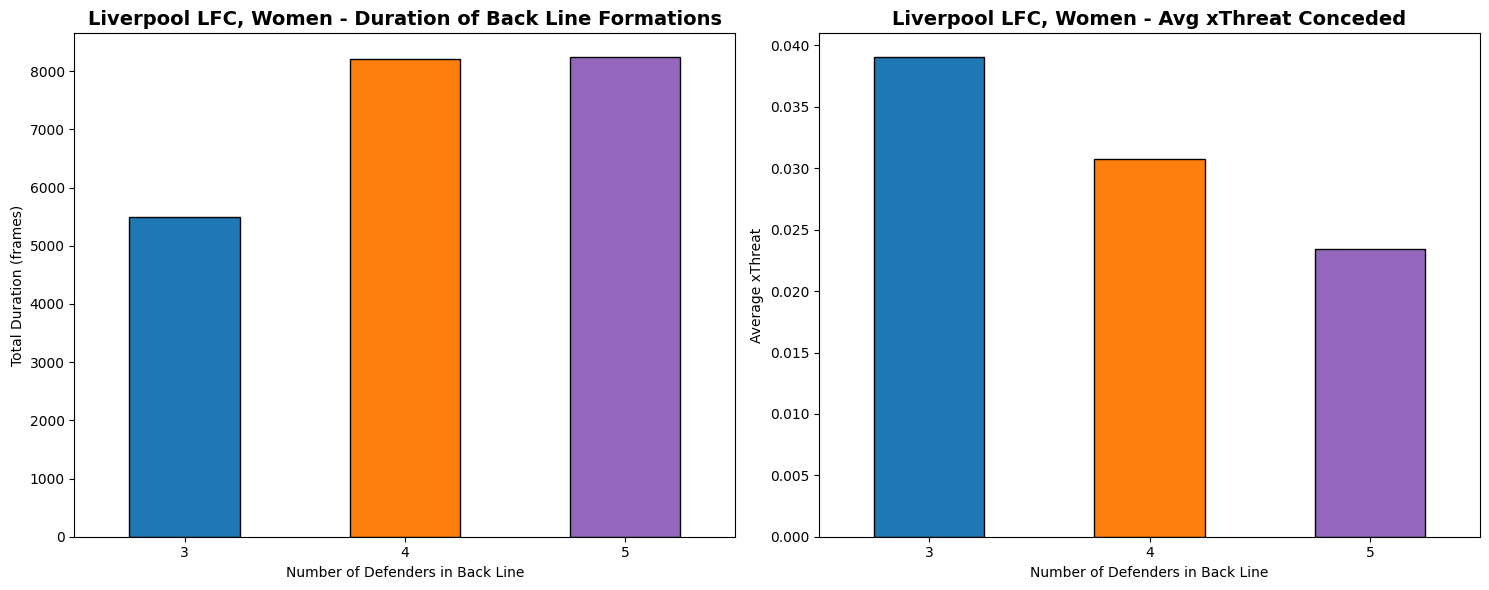

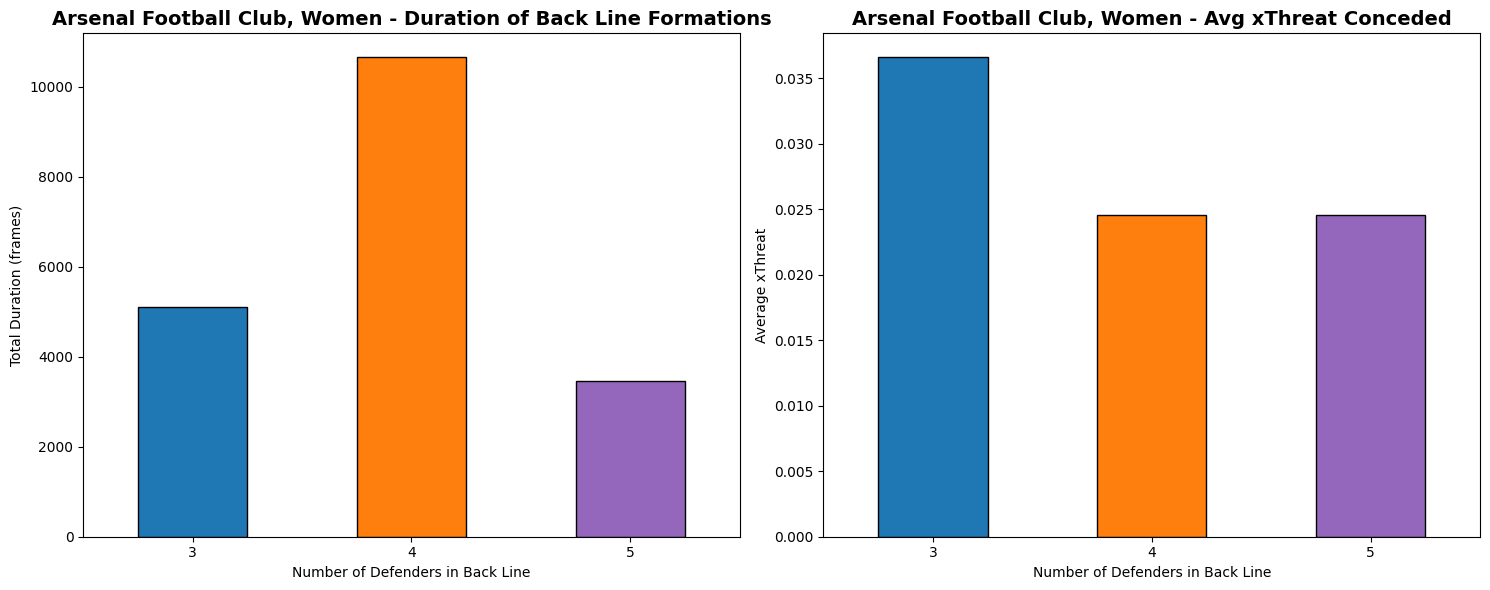

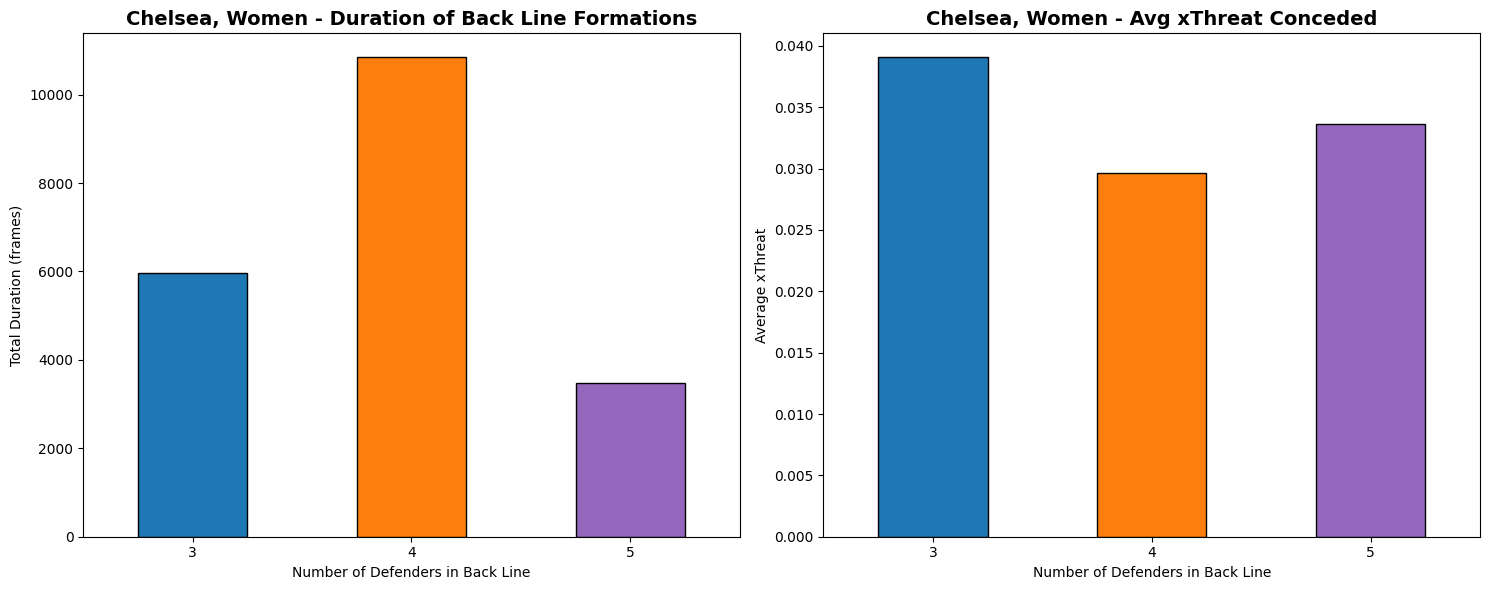

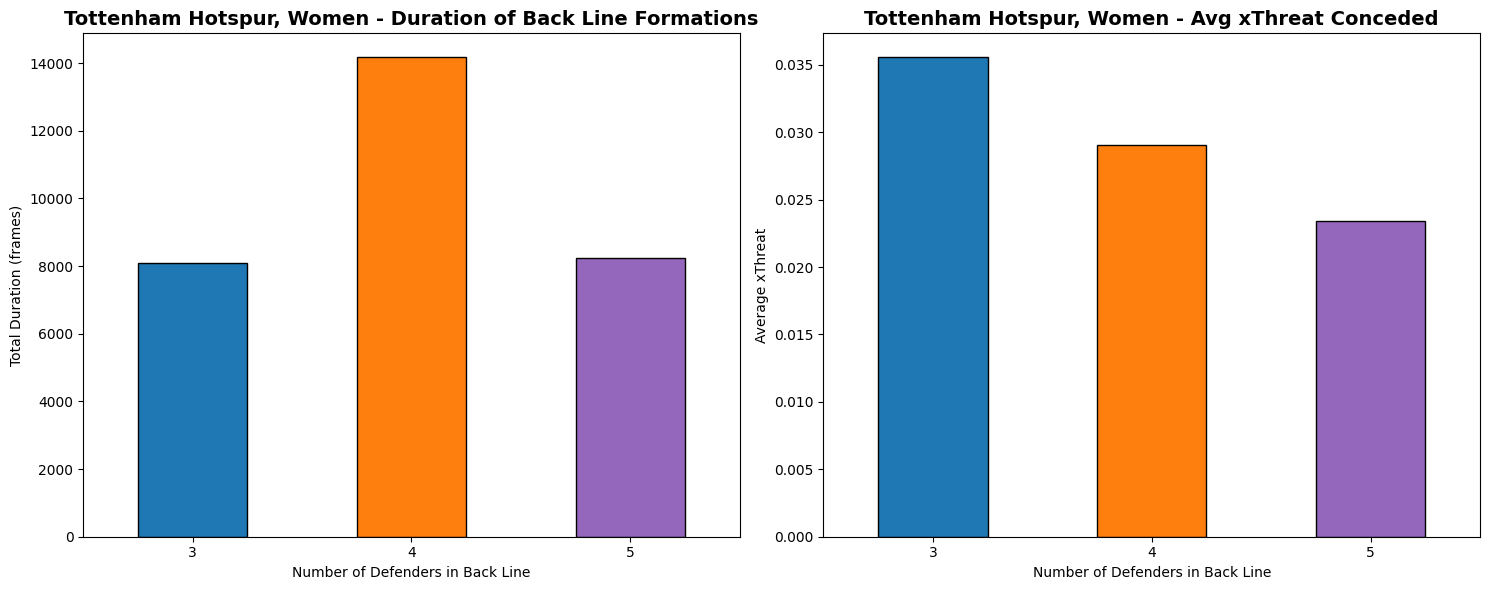

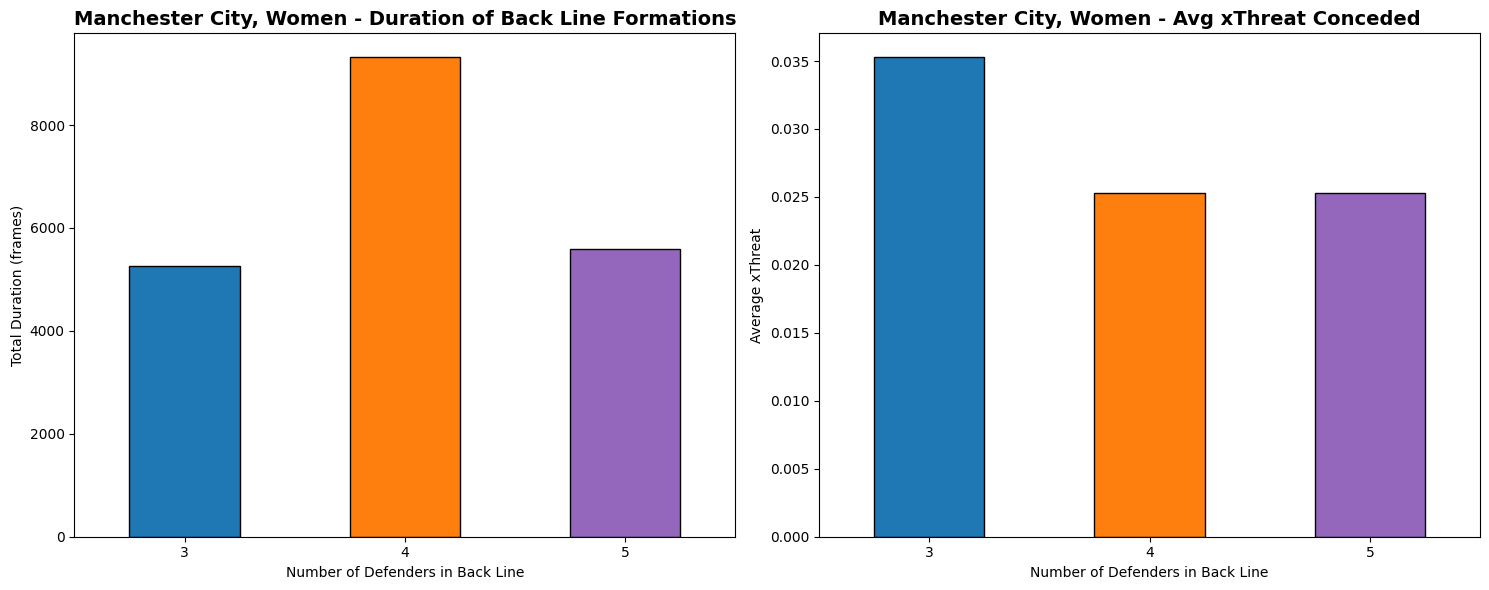

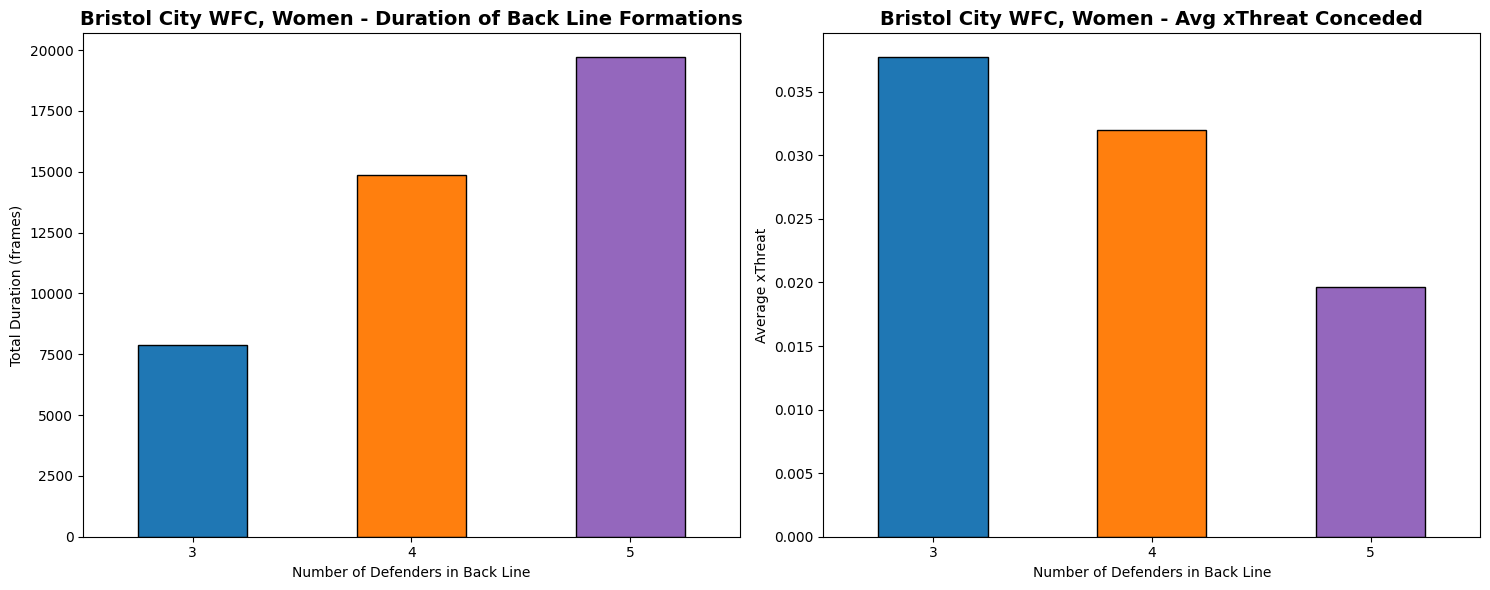

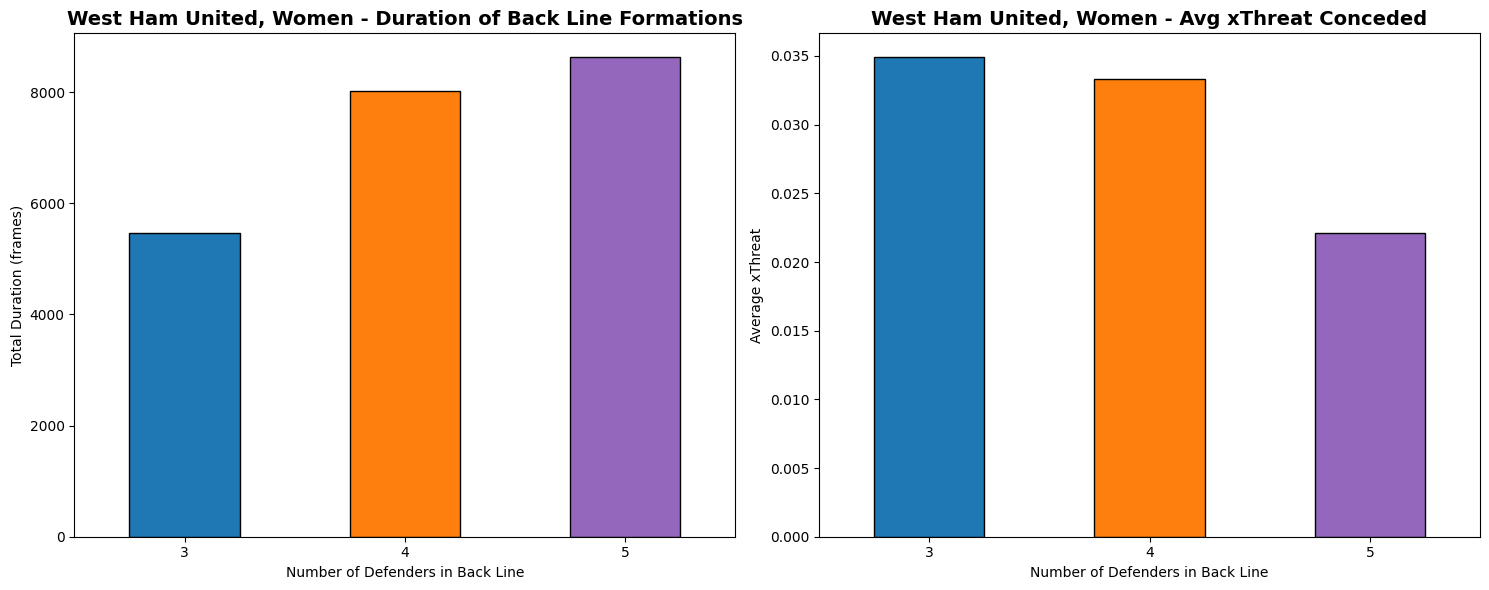

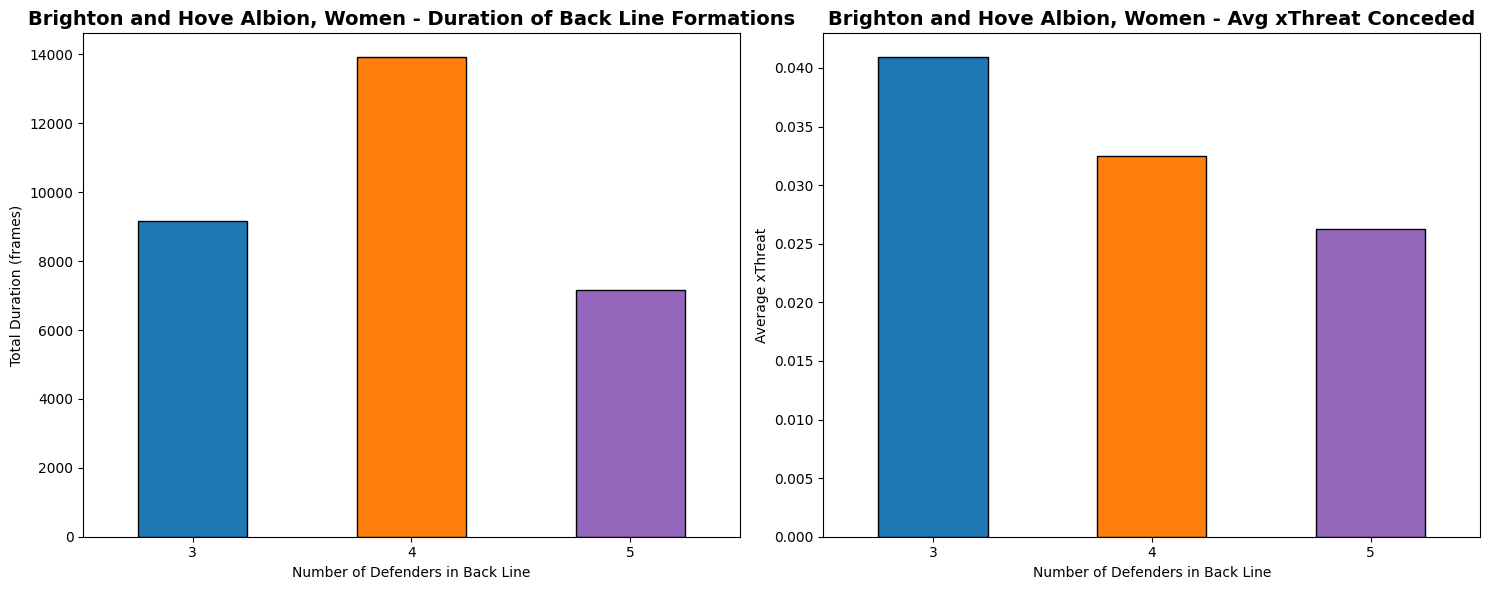

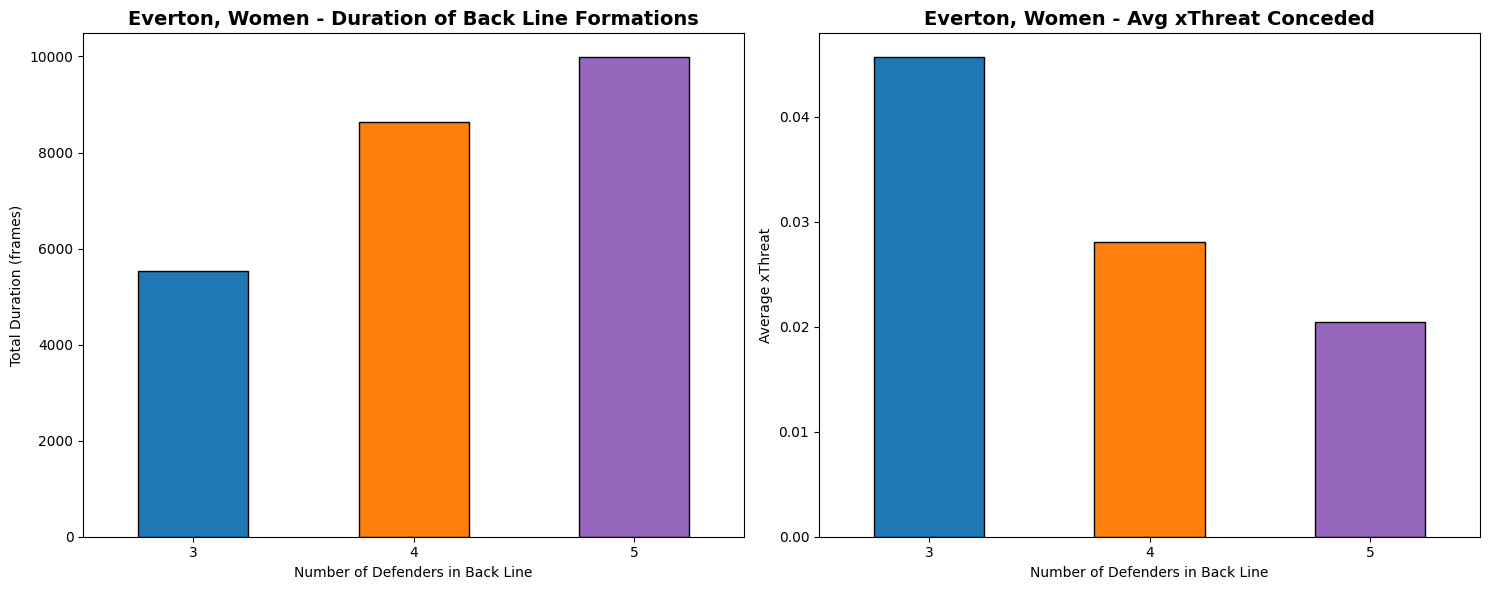

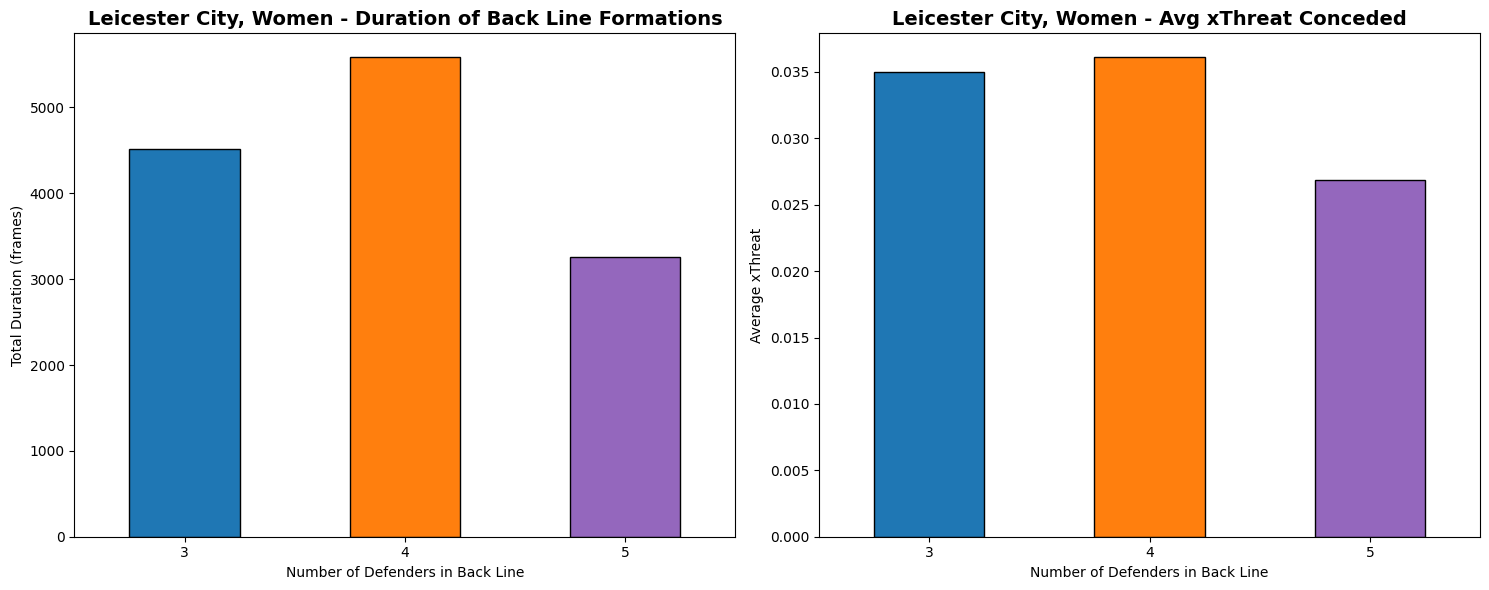

In [41]:
def analyze_formation_duration_teamwise(df):
    if df is None or not all(col in df.columns for col in ['back_line_count', 'team_id', 'frame_start', 'frame_end', 'player_targeted_xthreat']):
        print("No data available or missing required columns")
        return

    teams = df['opponent_id'].dropna().unique()

    for team in teams:
        team_df = df[df['opponent_id'] == team].copy()
        team_df['duration'] = team_df['frame_end'] - team_df['frame_start']

        formation_summary = (
            team_df.groupby('back_line_count')
            .agg(total_duration=('duration', 'sum'),
                 avg_xthreat=('player_targeted_xthreat', 'mean'))
            .sort_index()
            .reset_index()
        )

        bar_colors = [colors.get(x, '#CCCCCC') for x in formation_summary['back_line_count']]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        formation_summary.plot(
            x='back_line_count',
            y='total_duration',
            kind='bar',
            ax=ax1,
            color=bar_colors,
            edgecolor='black',
            legend=False
        )
        ax1.set_title(f'{team_mapping[team]} - Duration of Back Line Formations', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Number of Defenders in Back Line')
        ax1.set_ylabel('Total Duration (frames)')
        ax1.tick_params(axis='x', rotation=0)

        # sns.barplot(
        #     data=formation_summary,
        #     x='back_line_count',
        #     y='avg_xthreat',
        #     ax=ax2,
        #     palette=bar_colors
        # )
        formation_summary.plot(
            x='back_line_count',
            y='avg_xthreat',
            kind='bar',
            ax=ax2,
            color=bar_colors,
            edgecolor='black',
            legend=False
        )
        ax2.set_title(f'{team_mapping[team]} - Avg xThreat Conceded', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Number of Defenders in Back Line')
        ax2.set_ylabel('Average xThreat')
        ax2.tick_params(axis='x', rotation=0)
        plt.tight_layout()
        plt.show()
        
analyze_formation_duration_teamwise(possessions_analysis)

